# Import

In [161]:
import os
import re
import urllib
import requests

import pandas as pd

import numpy as np

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from PIL import Image
from PIL import ImageOps

import skimage
import skimage.feature
import skimage.viewer

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

import ipyplot

In [162]:
scaler=MinMaxScaler()

# Data Scraping

Get the list of flags from Wikipedia and save them

In [163]:
def get_flags():
    # Get list of flag urls
    site="https://en.wikipedia.org/wiki/Gallery_of_sovereign_state_flags"
    result = requests.get(site)
    soup=BeautifulSoup(result.text, 'html.parser')
    divs=soup.findAll('div', class_="mod-gallery mod-gallery-default")
    f=[]
    for x in divs:
        for y in x.findAll('img'):
            f.append(y)
    flags=[x.get('src') for x in f]
    # For each flag download it
    if not os.path.exists('flags'):
        os.makedirs('flags')
    for u in flags:
        url='https:'+u
        #print(url)
        p=url.split('/')[-1]
        urllib.request.urlretrieve(url, 'flags/'+p)

In [164]:
#Wikipedia get annoyed with a lot of scraping, only do it the first time
#get_flags()

# Read in Files

In [165]:
# Create a list of all RGBA colours present across all flags
colour_list_all=[]
# Create a list of main colours (i.e. not including aliasing)
colour_list=[]
# Create a list containg each country name, flag file name, and image data to be later coverted to dataframe
flag_list=[]

for i in os.listdir('flags'):
    # Read in flag and convert to rgba
    name=re.search('Flag_of_(.+)\.svg', i).groups()[0]
    im = Image.open('flags/'+i)
    rgbimg = im.convert('RGBA')
    flag_list.append([name, i, rgbimg])
    # Get list of colours in flag
    size=0
    my_dict={}
    for pixel in rgbimg.getdata():
        size+=1
        if pixel in my_dict:
            my_dict[pixel]+=1
        else:
            my_dict[pixel]=1
    #Remove colours present in small amounts due to aliasing
    for k, v in dict(my_dict).items():
        colour_list_all.append(k)
        if v/size<0.1:
            my_dict.pop(k)
        else:
            colour_list.append(k)

In [166]:
#flag_list

# Colour normalisation

Flags use many different shades of colours, so here they are clustered to find basic shades. This will allow easier comparisons

In [167]:
#Remove transparent pixels due to shape of Nepalese flag
colour_list.remove((0, 0, 0, 0))
# Convert to data frame and drop Alpha channel
colours=pd.DataFrame(colour_list, columns=['R', 'G', 'B', 'A'])
colours=colours.drop('A', axis=1)
colours

R    G    B
0     35  159   64
1    255  255  255
2    218    0    0
3      0    0    0
4    206   17   38
..   ...  ...  ...
513  255  255  255
514    0   92  229
515  255    0    0
516  255  255  255
517    1   65   28

[518 rows x 3 columns]

In [168]:
# Explore to find best number of clusters
k_range = range(5, 15)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(colours)
    scores.append(metrics.silhouette_score(colours, kmT.labels_))
    inertia.append(kmT.inertia_)

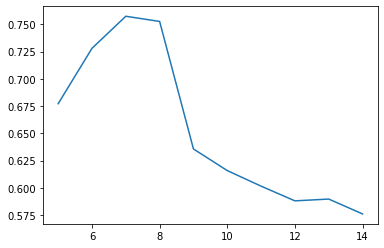

In [169]:
plt.plot(k_range, scores)

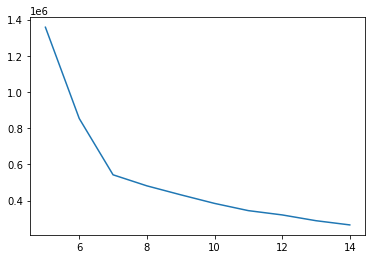

In [170]:
plt.plot(k_range, inertia)

In [171]:
cluster_size=7

In [172]:
km_colours = KMeans(n_clusters=cluster_size, random_state=124)
km_colours.fit(colours[['R', 'G', 'B']])

KMeans(n_clusters=7, random_state=124)

In [173]:
# Get the average colour in each cluster
base_colours=km_colours.cluster_centers_

In [174]:
fig = px.imshow([base_colours])
fig.show()

In [175]:
colours['cluster']=km_colours.labels_.astype(str)

In [176]:
# Map how the colour spectrum has been clustered
color_discrete_map={}
for i in range(0, len(base_colours)):
    color_discrete_map[str(i)]='rgb('+str(round(base_colours[i][0]))+','+str(round(base_colours[i][1]))+','+str(round(base_colours[i][2]))+')'
fig=px.scatter_ternary(colours, a='R', b='G', c='B', color='cluster', color_discrete_map=color_discrete_map)
fig.show()

## Normalise Flags Colours in conversion to DataFrame

This takes all the flag images and converts them to the colour palette created above

In [177]:
# For each colour present in flag images, add a dictionary entry with their predicted cluster
colour_dictionary={}
for i in colour_list_all:
    #print(i[0:3])
    colour_dictionary[i]=km_colours.predict([[i[0], i[1], i[2]]])[0]

In [178]:
# Convert colours to palette and add to list of what colours are present in what quantity
def normalised_colour_list(img, palette):
    data = img.getdata()
    colours = []
    for item in data:
        colours.append(palette[item])
    return colours

In [179]:
# Create empty data frame to populate after conversion
cols=[x for x in range(0, len(base_colours))]
df=pd.DataFrame(columns=['Country', 'file']+cols)

In [180]:
# For each flag get the percentage of each colour present and add to dataframe
for i in flag_list:
    colour_percentage=[0]*(len(cols))
    my_dict={}
    size=0
    flag_colours=normalised_colour_list(i[2], colour_dictionary)
    for pixel in flag_colours:
        size+=1
        if pixel in my_dict:
            my_dict[pixel]+=1
        else:
            my_dict[pixel]=1
    for k, v in dict(my_dict).items():
        colour_percentage[k]=v
    colour_percentage=[100*round(x/size, 2) for x in colour_percentage]
    df.loc[len(df)] =[i[0], i[1]]+colour_percentage

In [181]:
df

Country                               file     0     1     2     3  \
0           Iran         175px-Flag_of_Iran.svg.png   0.0   1.0  37.0  32.0   
1         Jordan       180px-Flag_of_Jordan.svg.png   0.0   0.0  20.0  25.0   
2        Georgia      150px-Flag_of_Georgia.svg.png   0.0   0.0  64.0  36.0   
3         Poland       160px-Flag_of_Poland.svg.png   0.0   0.0  50.0  50.0   
4           Fiji         180px-Flag_of_Fiji.svg.png   7.0   2.0  11.0  13.0   
..           ...                                ...   ...   ...   ...   ...   
201  Saint_Lucia  180px-Flag_of_Saint_Lucia.svg.png   0.0   7.0   3.0   0.0   
202       Belize       167px-Flag_of_Belize.svg.png  64.0   1.0   9.0  21.0   
203     Colombia     150px-Flag_of_Colombia.svg.png  25.0  50.0   0.0  25.0   
204     Slovenia     180px-Flag_of_Slovenia.svg.png   0.0   0.0  32.0  34.0   
205     Pakistan     150px-Flag_of_Pakistan.svg.png   0.0   0.0  31.0   0.0   

        4     5     6  
0    29.0   0.0   2.0  
1    28.0  28.0   0.0  
2     0.0   0.0   0.0  
3     0.0   0.0   0.0  
4     1.0   0.0  66.0  
..    ...   ...   ...  
201   0.0   3.0  86.0  
202   4.0   0.0   1.0  
203   0.0   0.0   0.0  
204   0.0   0.0  34.0  
205   1.0  67.0   1.0  

[206 rows x 9 columns]

## Cleaning up Names

In [182]:
#df['Country'].unique()

In [183]:
# Some symbols do not show properly, and some flag names have modifiers. This cleans them
df['Country']=df['Country'].str.replace('%C3%B4', 'ô')
df['Country']=df['Country'].str.replace('_%28converted%29', '')
df['Country']=df['Country'].str.replace('_%28Pantone%29', '')
df['Country']=df['Country'].str.replace('_%28civil%29', '')
df['Country']=df['Country'].str.replace('_', ' ')
df['Country']=df['Country'].str.replace('%27', '\'')

## Clustering by colour percentage

This is the first of several clusterings, done first separately then combined for different criteria. This simply clusters by the percentage of each colour present

In [184]:
X=df[[x for x in range(0, len(base_colours))]]

In [185]:
# Same methodology as above
k_range = range(5, 100)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(X)
    scores.append(metrics.silhouette_score(X, kmT.labels_))
    inertia.append(kmT.inertia_)

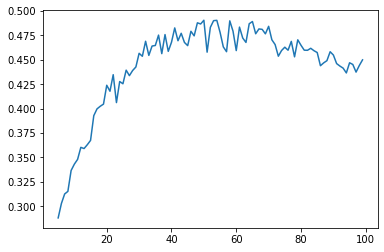

In [186]:
plt.plot(k_range, scores)

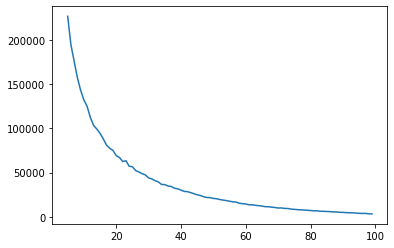

In [187]:
plt.plot(k_range, inertia)

In [188]:
#z=list(zip(k_range, scores))
#for i in z:
#    print(i)

In [189]:
cluster_size=22

In [190]:
km = KMeans(n_clusters=cluster_size, random_state=124)
km.fit(X)
df['colour_cluster']=km.labels_

In [191]:
# Use ipyplot to create an easy to view list of clusters and items
def view_cluster(data, cluster):
    pics=[]
    labels=[]
    names=[]
    for i in range(0, data[cluster].nunique()):
        cluster_list=[]
        im_u=data[data[cluster]==i]['file'].tolist()
        l=data[data[cluster]==i][cluster].tolist()
        n=data[data[cluster]==i]['Country'].tolist()
        for j in im_u:
            cluster_list.append(Image.open('flags/'+str(j)))
        pics.extend(cluster_list)
        labels.extend(l)
        names.extend(n)
    ipyplot.plot_class_tabs(pics, labels, custom_texts=names)

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: FutureWarning:

The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.




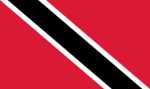
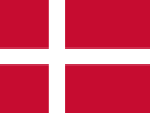
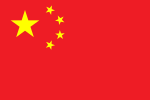
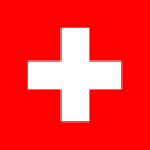
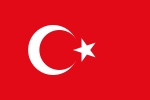
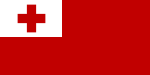
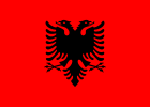
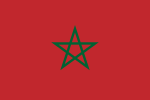
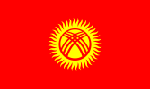
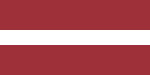
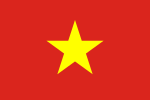
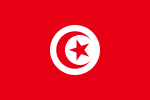
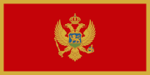
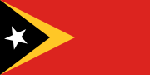
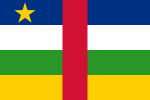
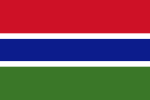
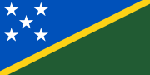
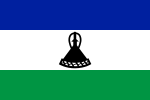
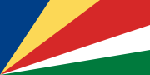
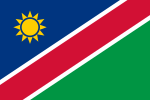
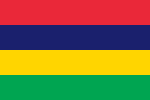
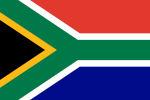
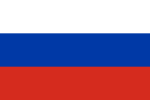
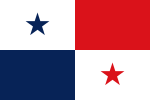
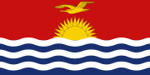
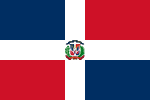
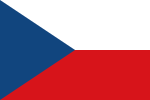
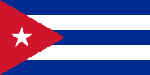
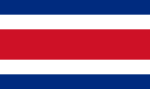
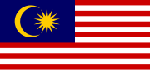
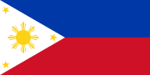
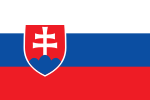
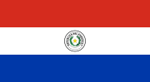
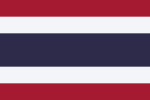
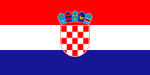
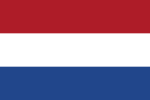
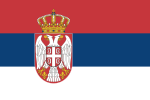
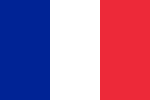
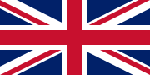
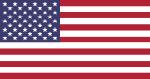
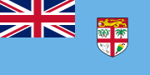
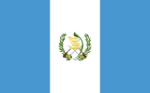
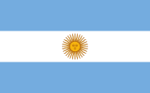
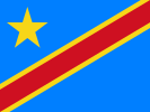
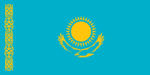
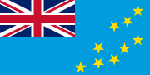
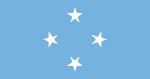
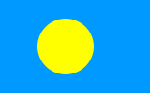
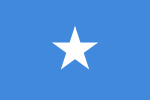
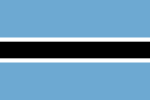
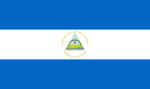
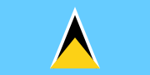
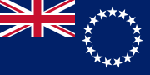
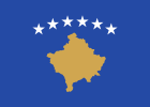
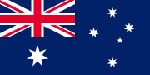
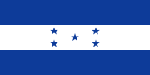
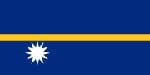
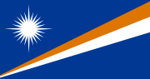
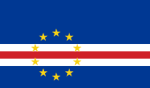
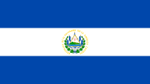
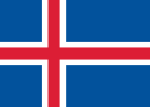
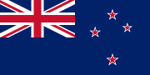
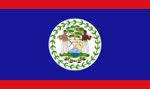
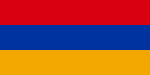
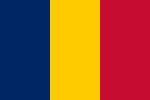
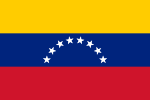
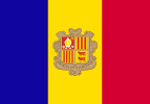
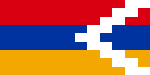
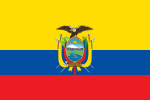
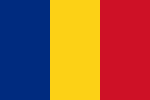
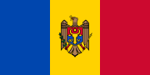
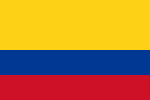
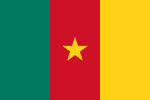
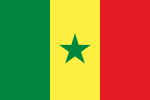
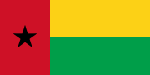
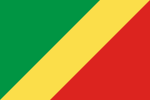
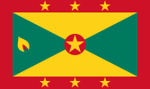
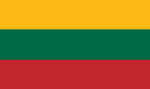
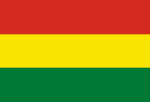
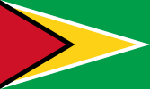
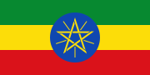
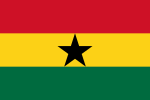
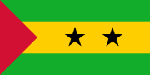
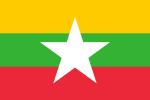
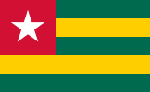
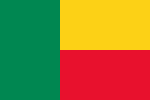
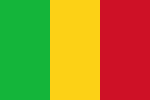
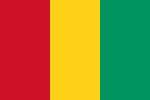
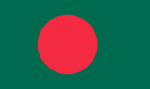
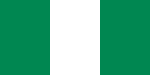
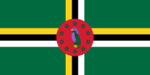
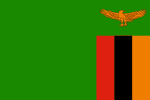
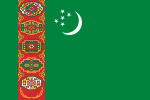
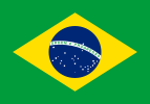
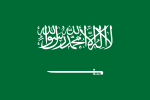
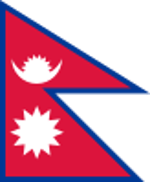
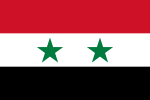
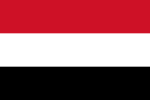
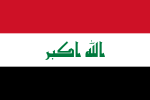
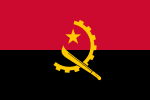
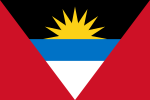
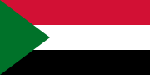
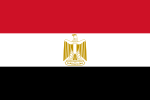
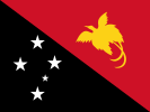
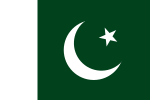
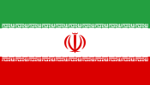
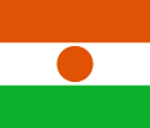
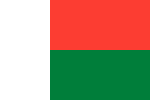
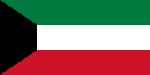
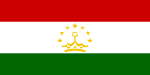
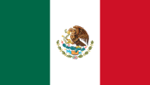
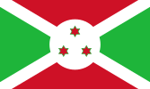
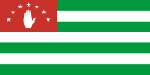
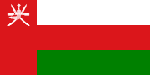
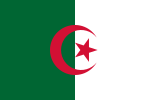
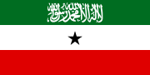
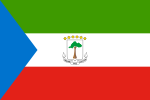
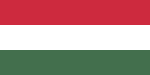
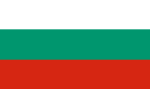
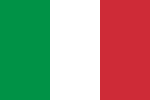
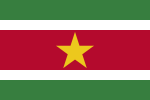
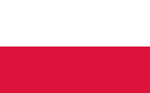
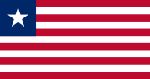
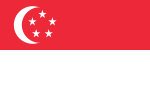
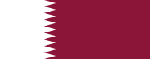
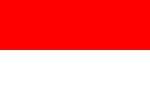
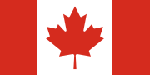
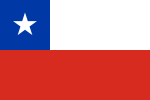
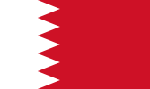
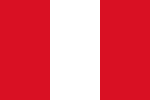
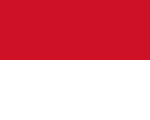
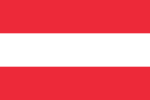
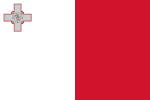
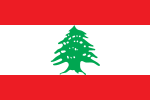
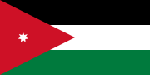
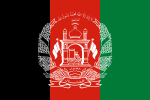
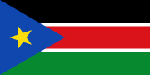
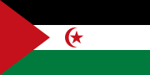
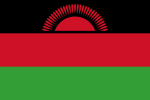
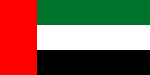
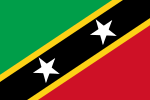
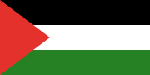
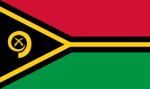
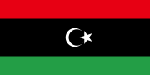
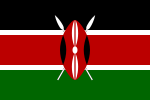
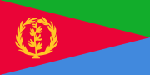
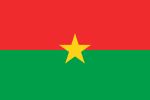
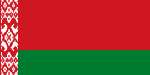
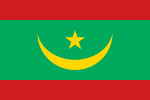
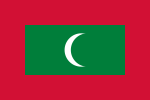
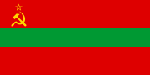
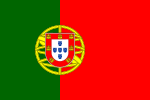
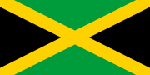
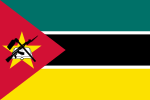
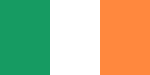
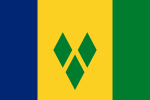
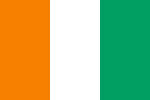
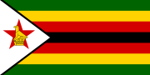
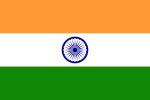
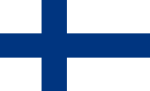
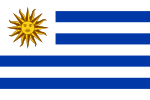
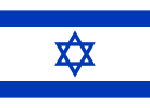
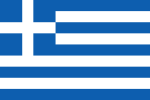
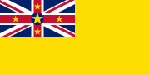
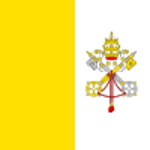
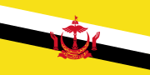
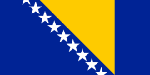
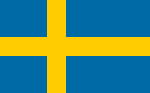
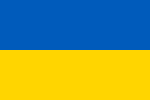
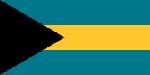
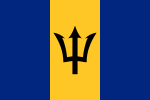
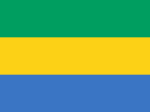
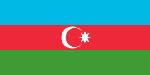
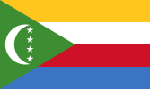
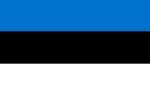
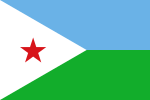
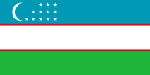
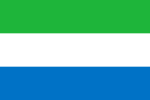
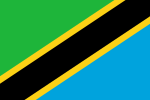
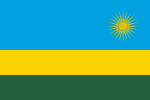
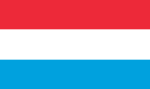
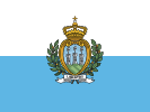
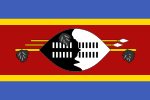
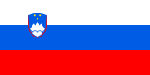
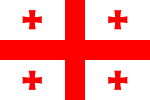
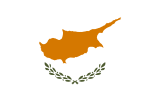
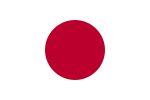
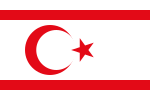
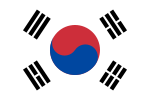
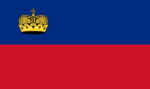
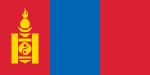
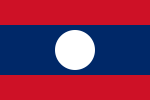
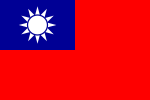
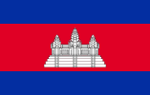
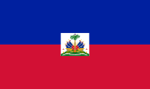
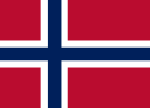
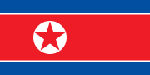
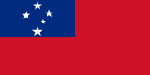
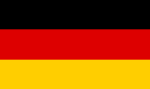
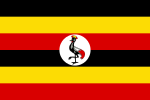
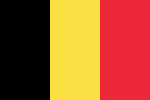
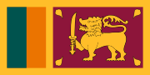
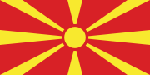
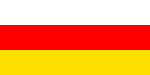
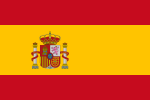
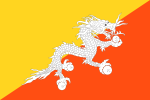


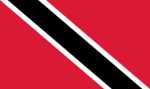
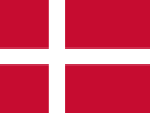
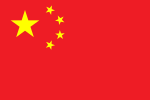
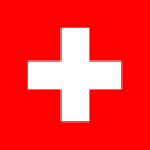
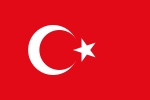
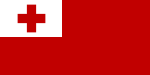
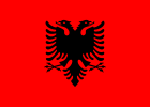
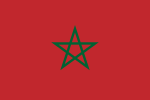
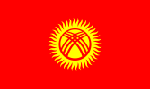
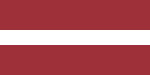
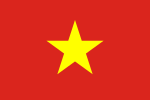
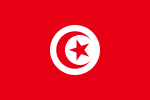
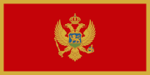
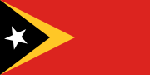
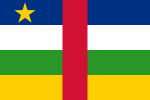
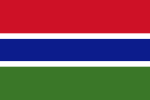
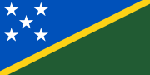
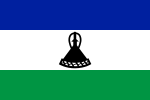
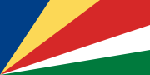
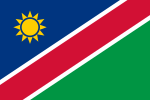
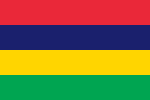
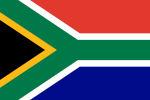
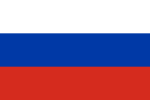
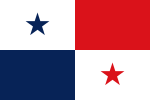
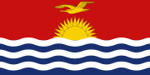
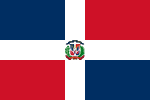
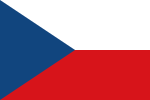
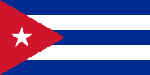
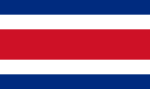
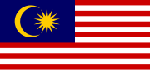
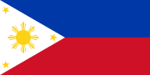
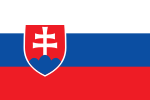
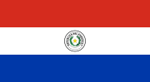
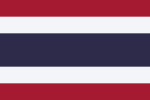
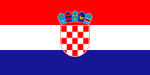
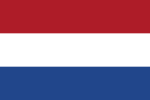
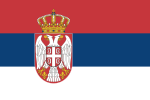
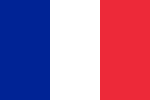
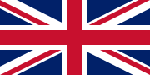
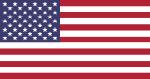
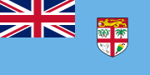
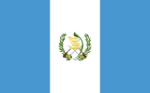
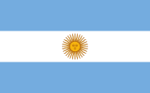
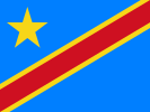
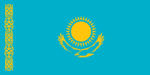
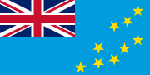
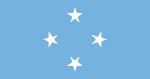
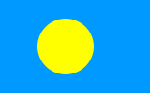
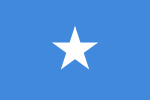
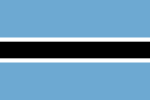
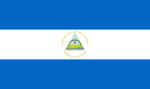
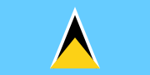
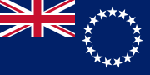
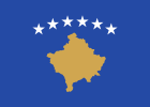
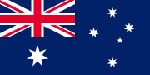
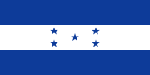
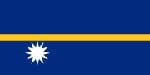
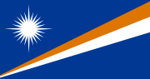
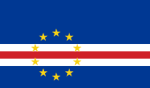
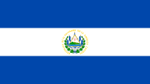
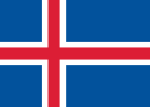
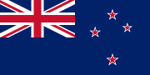
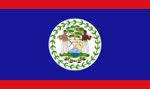
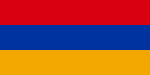
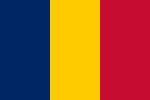
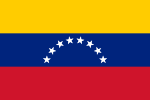
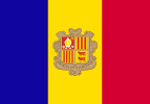
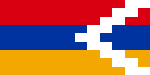
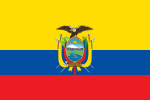
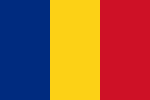
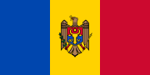
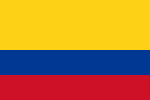
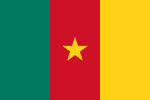
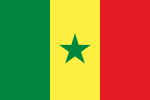
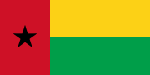
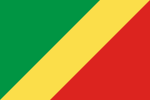
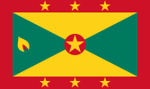
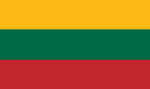
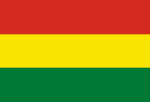
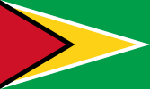
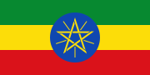
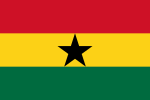
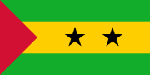
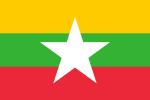
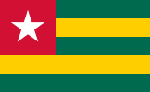
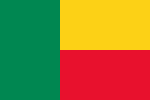
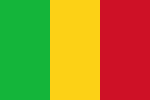
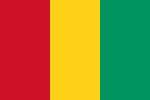
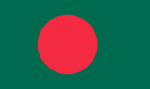
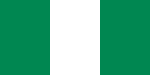
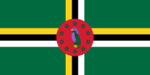
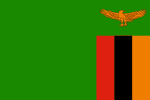
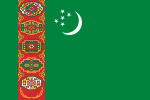
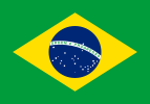
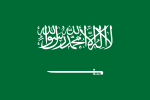
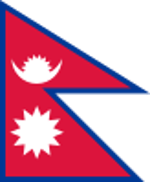
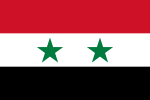
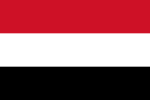
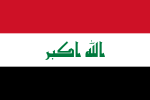
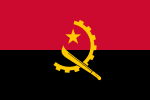
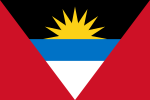
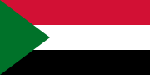
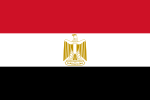
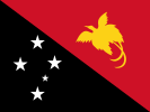
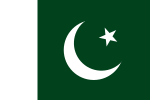
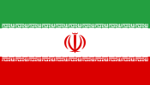
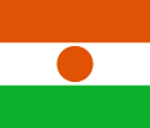
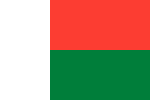
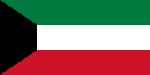
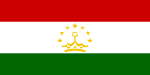
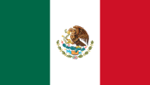
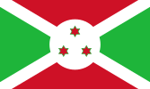
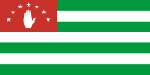
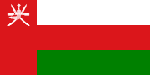
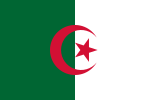
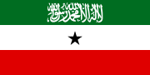
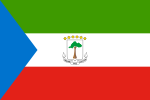
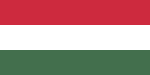
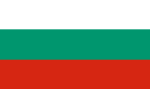
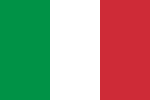
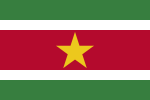
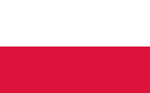
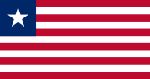
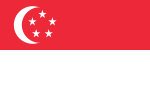
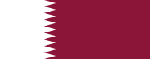
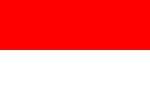
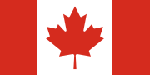
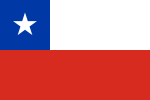
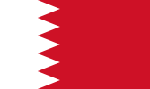
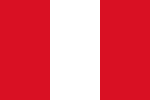
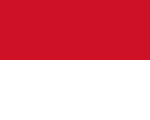
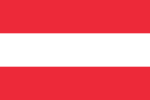
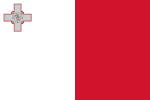
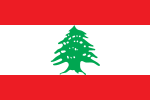
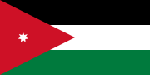
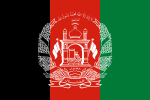
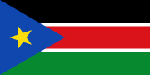
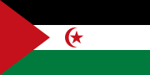
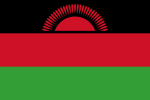
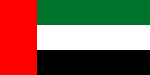
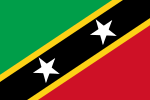
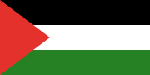
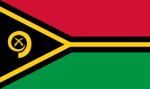
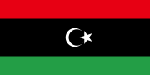
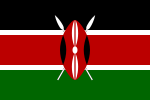
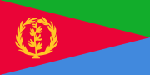
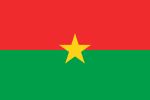
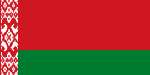
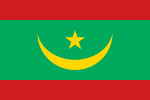
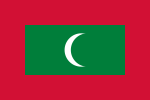
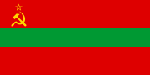
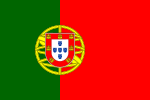
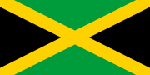
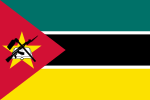
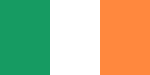
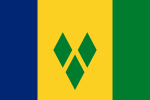
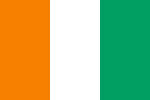
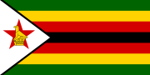
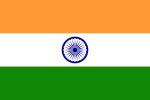
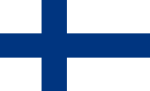
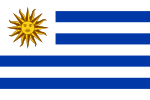
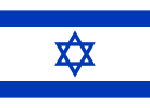
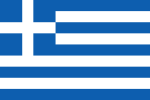
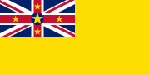
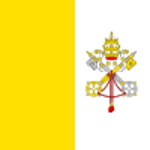
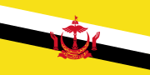
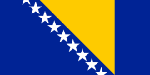
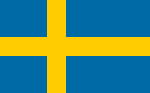
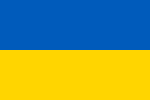
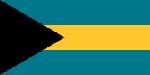
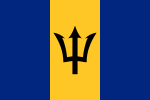
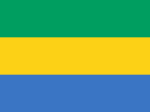
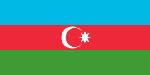
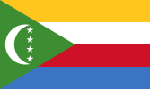
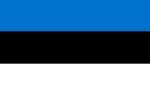
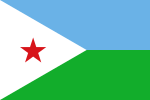
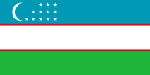
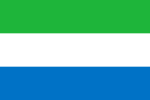
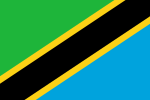
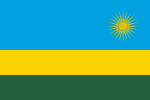
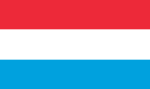
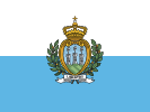
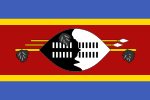
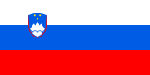
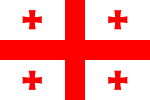
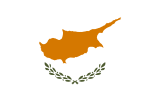
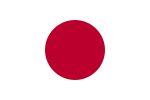
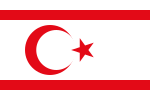
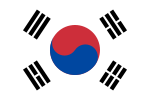
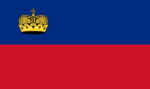
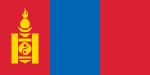
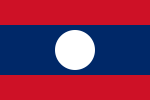
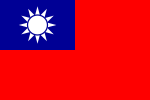
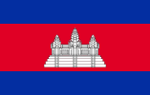
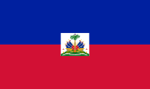
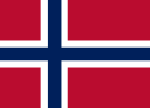
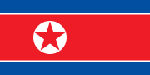
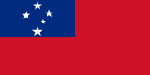
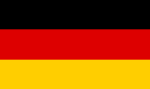
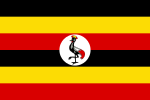
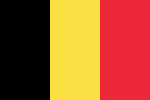
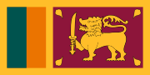
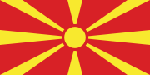
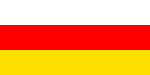
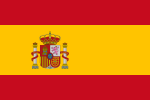
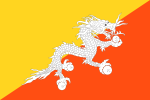

In [192]:
view_cluster(df, 'colour_cluster')

# Edge Cluster

This is the second clustering which aims to group flags which have a similar shape

In [193]:
# For each flag use edge detection to convert to a black and white shape
flag_edges=[]
for i in flag_list:
    im=i[2]
    #im_c=im.convert('RGB')
    im_g=ImageOps.grayscale(im)
    #im_c = np.array(im_c)
    im_g = np.array(im_g)
    #im_c=skimage.transform.resize(im_c, (100, 180))
    im_g=skimage.transform.resize(im_g, (100, 180))
    edges = skimage.feature.canny(
        image=im_g,
        sigma=0,
        low_threshold=0,
        high_threshold=0.01,
    )
    #flag_norm.append(im_c)
    flag_edges.append(edges)
flag_edges=np.array(flag_edges)

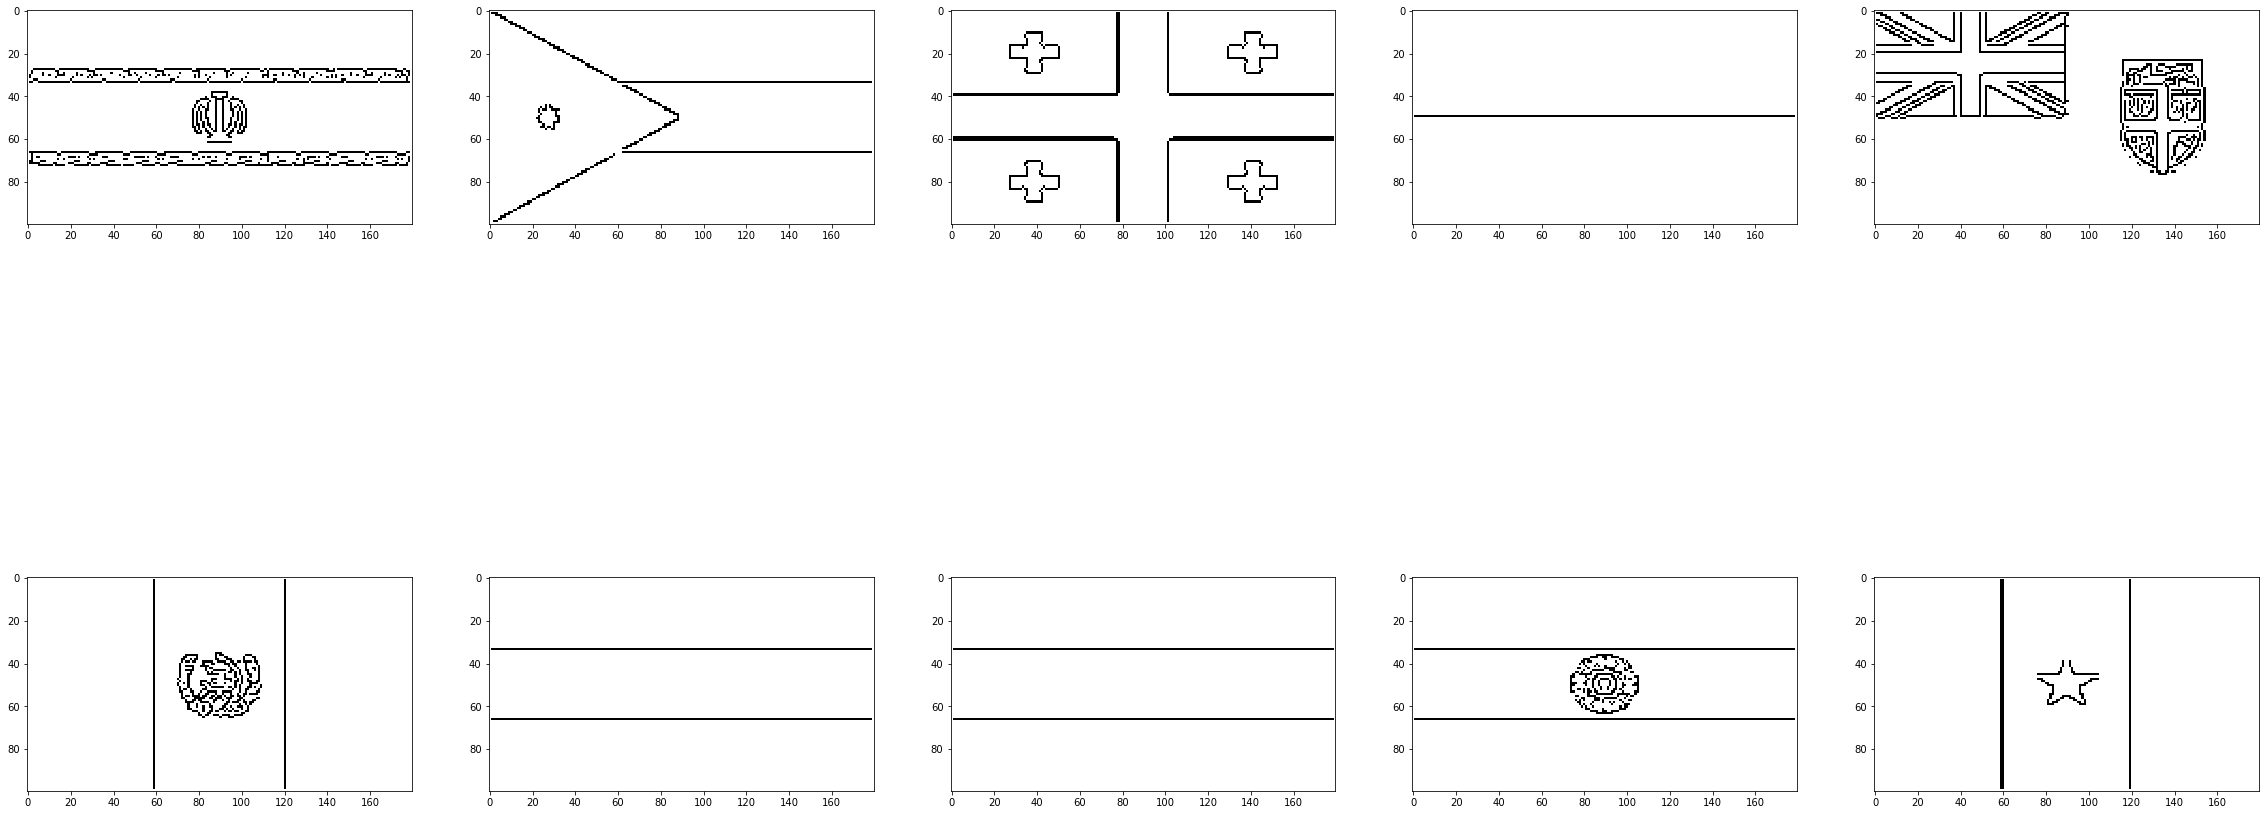

In [194]:
plt.figure(figsize=(40,40))
for i, image in enumerate(flag_edges[:10]):
    #initializing subplot of 3x5
    plt.subplot(4,5, i+1)
    #display images in the subplots
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

To group the flag shapes, analysis is done with the VGG16 image recognition network.
Principal Component Analysis (PCA) is done and used to create the clusters

In [195]:
x = preprocess_input(flag_edges)
model=VGG16(weights=None, classes=25,input_shape=(100, 180, 1))
model= Model(inputs=model.inputs, outputs=model.layers[-2].output)
f=model.predict(x)

In [196]:
pca=PCA(n_components=100, random_state=22)
pca.fit(f)
x=pca.transform(f)

Note that due to the behaviour of VGG16, clusters will not be the same on each run. After doing several runs a rough average of best is taken but it might not fit the graph on each subsequent run

In [197]:
k_range = range(5, 60)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(x)
    scores.append(metrics.silhouette_score(x, kmT.labels_))
    inertia.append(kmT.inertia_)

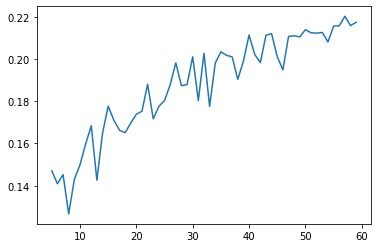

In [198]:
plt.plot(k_range, scores)

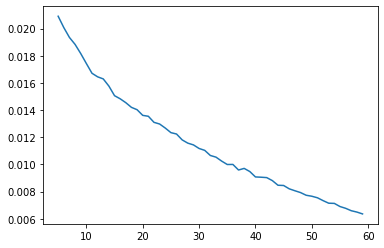

In [199]:
plt.plot(k_range, inertia)

In [200]:
#z=list(zip(k_range, scores))
#for i in z:
#    print(i)

In [201]:
cluster_size=31

In [202]:
km = KMeans(n_clusters=cluster_size, random_state=124)
km.fit(x)
df['edge_cluster']=km.labels_

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: FutureWarning:

The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.




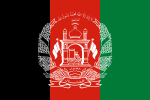
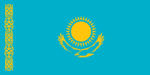
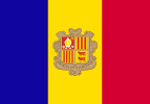
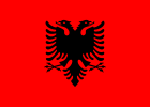
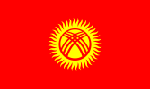
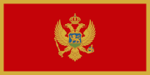
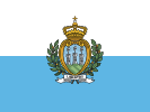
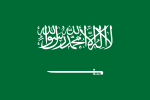
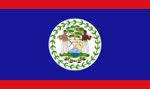
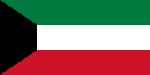
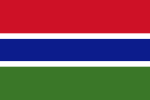
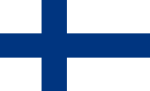
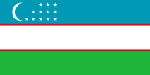
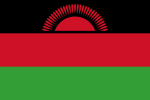
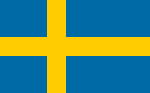
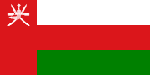
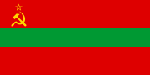
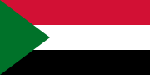
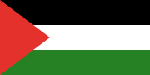
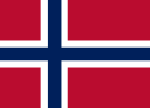
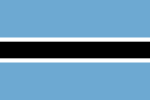
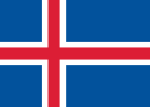
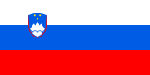
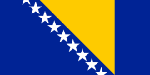
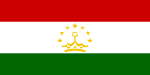
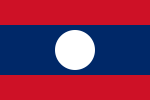
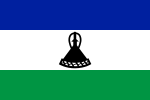
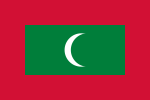
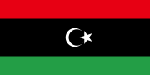
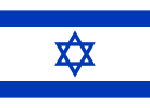
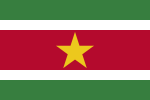
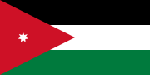
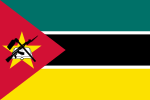
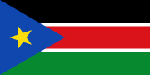
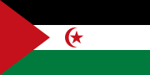
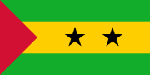
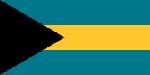
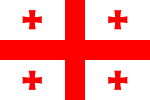
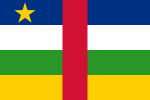
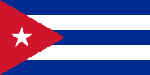
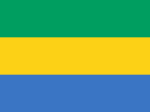
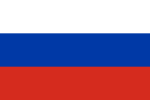
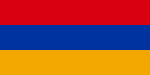
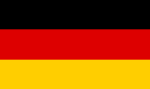
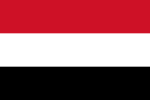
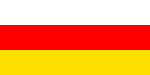
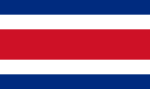
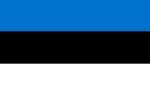
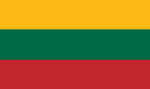
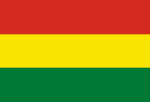
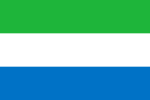
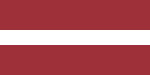
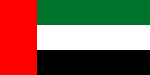
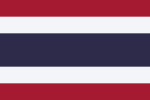
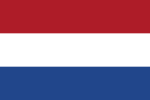
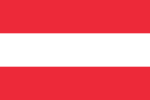
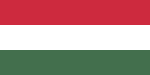
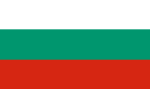
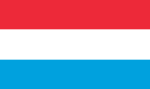
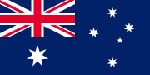
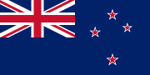
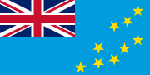
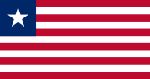
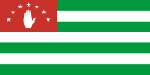
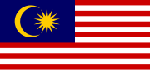
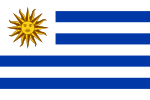
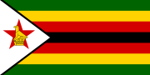
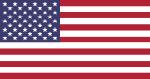
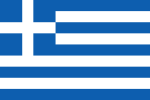
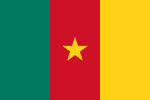
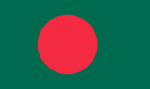
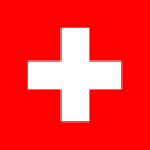
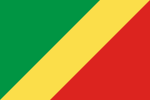
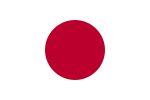
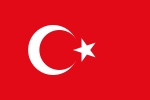
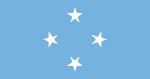
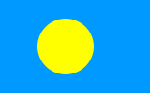
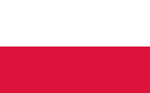
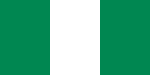
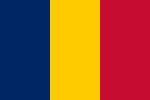
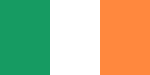
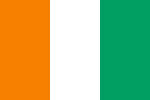
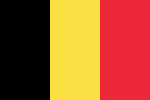
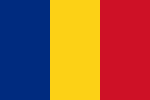
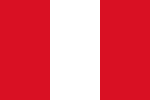
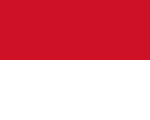
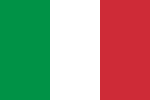
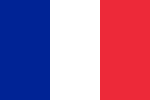
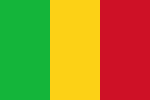
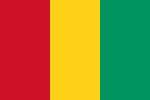
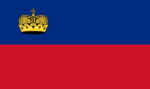
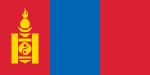
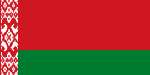
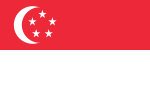
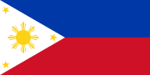
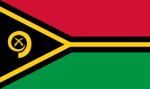
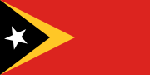
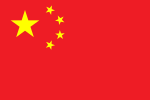
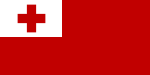
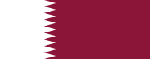
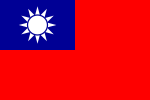
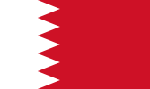
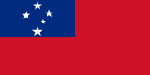
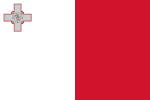
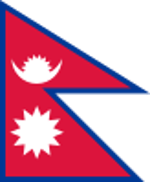
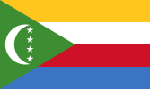
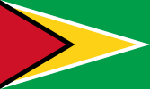
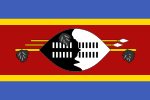
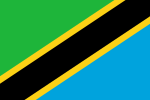
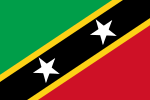
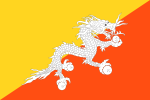
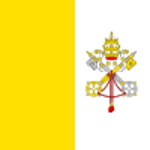
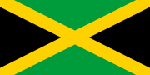
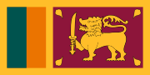
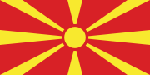
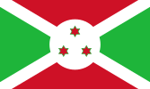
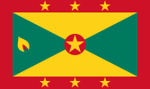
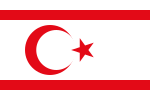
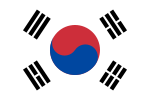
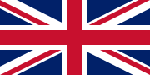
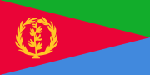
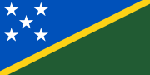
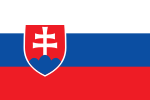
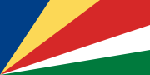
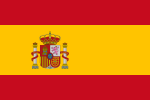
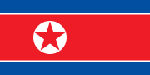
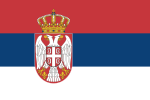
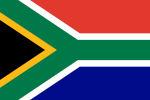
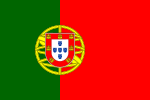
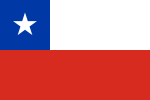
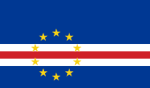
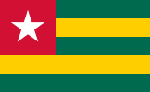
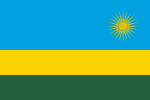
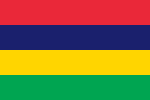
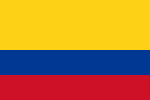
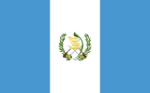
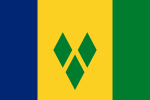
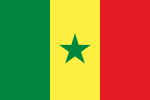
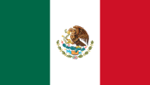
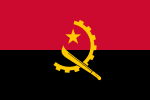
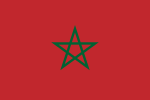
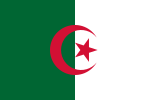
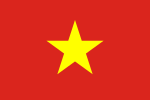
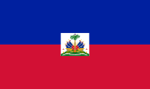
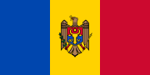
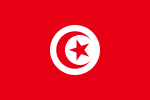
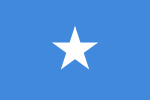
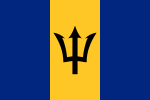
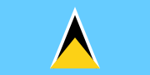
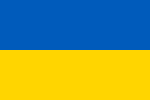
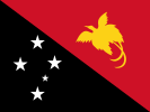
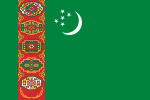
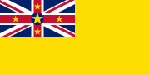
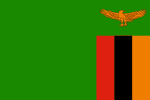
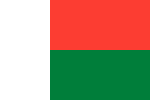
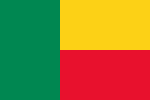
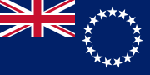
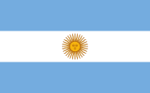
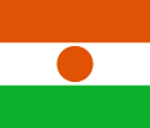
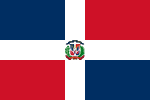
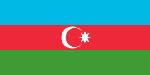
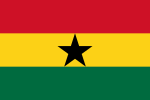
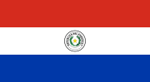
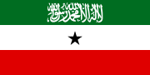
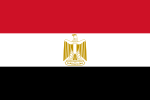
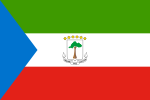
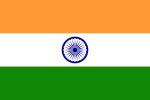
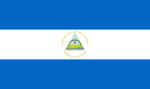
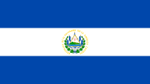
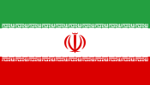
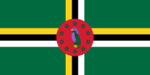
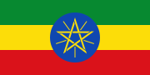
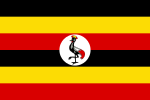
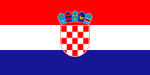
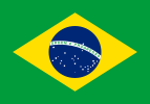
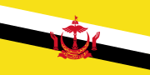
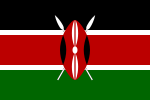
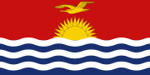
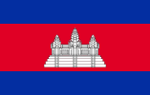
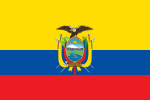
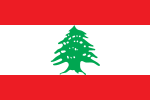
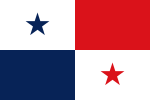
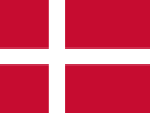
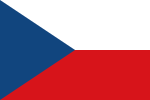
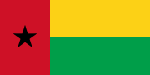
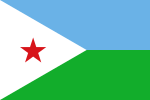
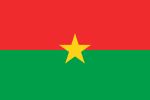
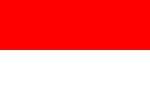
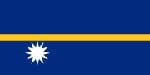
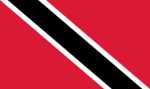
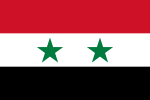
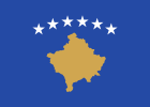
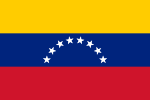
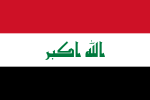
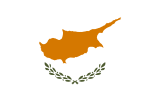
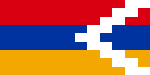
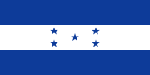
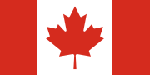
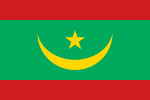
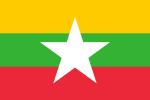
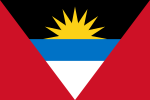
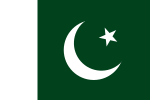
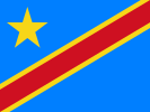
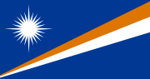
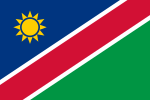
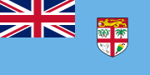


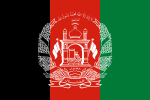
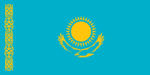
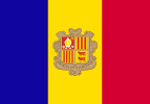
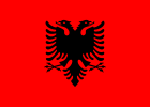
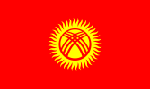
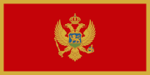
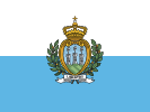
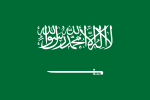
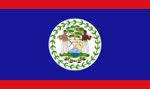
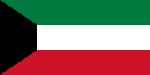
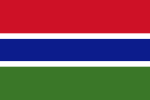
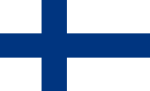
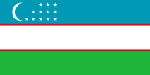
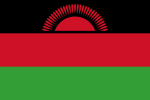
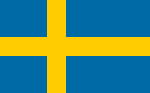
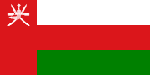
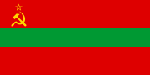
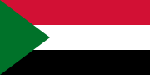
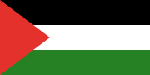
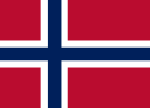
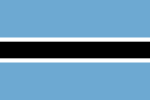
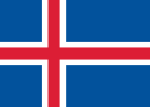
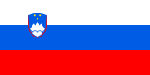
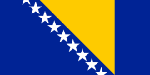
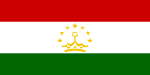
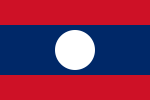
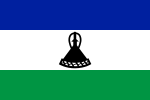
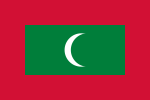
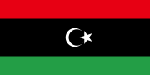
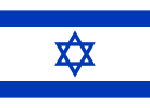
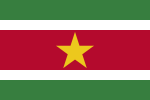
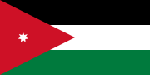
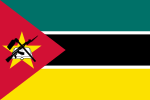
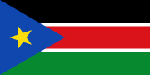
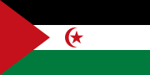
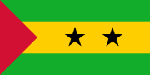
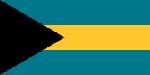
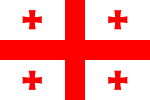
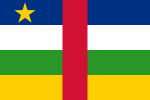
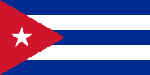
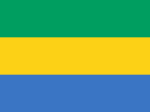
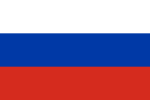
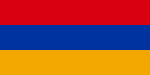
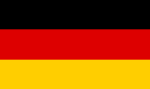
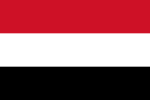
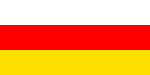
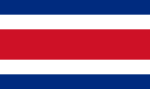
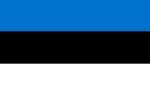
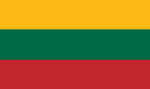
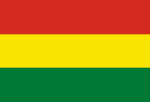
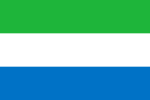
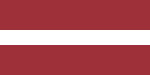
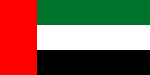
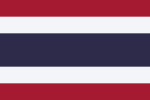
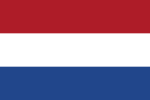
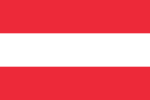
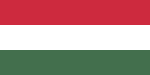
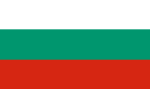
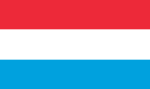
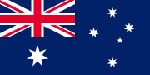
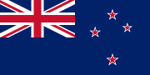
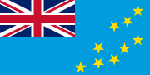
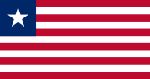
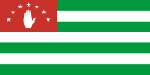
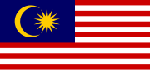
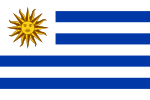
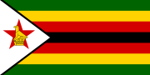
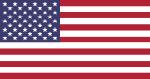
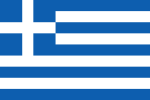
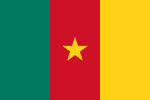
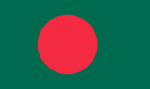
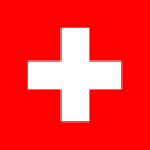
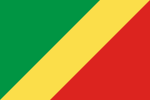
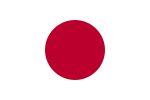
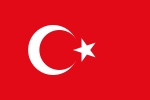
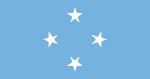
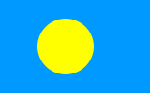
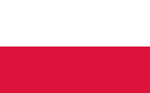
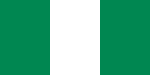
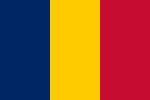
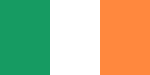
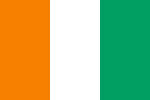
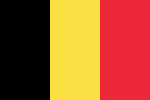
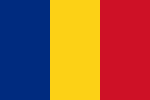
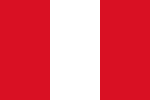
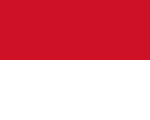
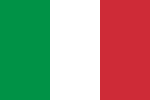
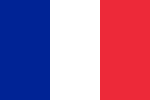
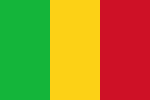
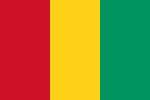
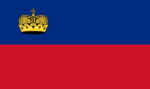
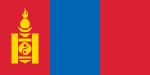
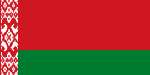
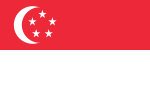
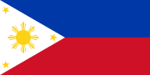
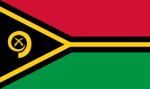
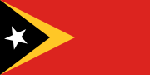
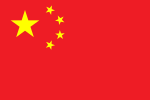
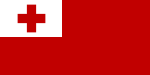
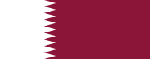
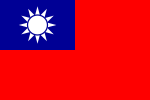
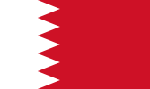
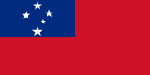
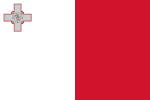
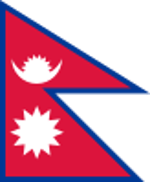
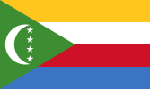
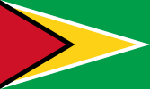
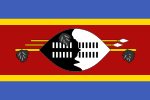
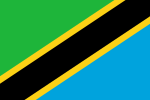
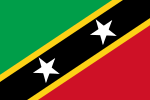
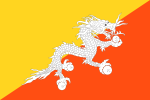
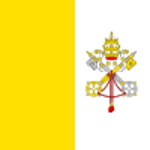
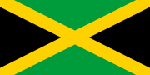
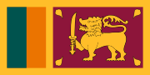
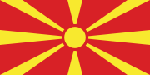
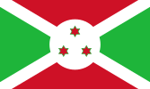
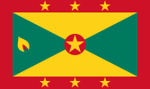
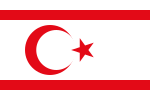
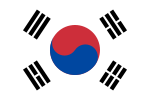
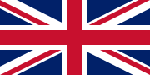
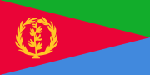
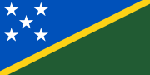
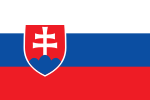
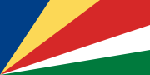
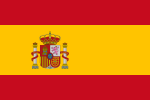
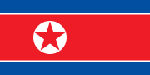
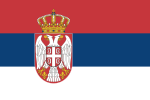
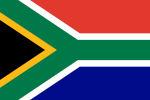
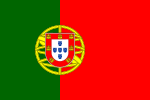
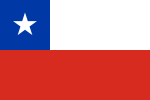
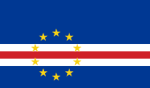
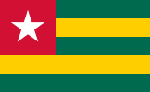
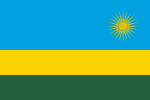
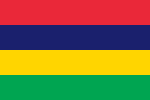
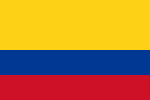
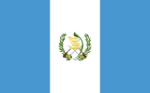
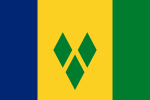
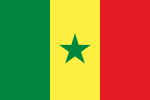
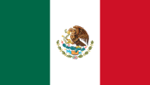
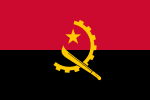
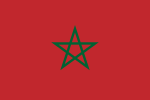
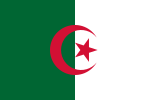
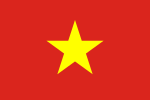
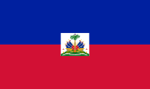
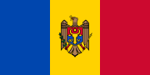
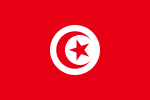
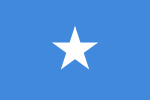
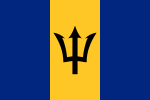
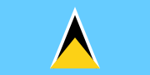
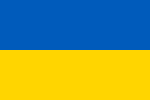
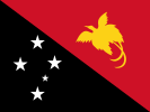
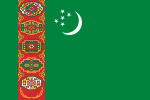
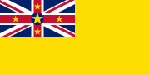
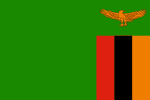
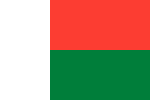
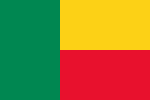
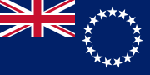
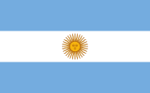
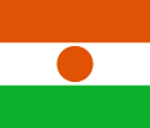
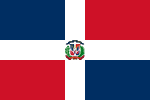
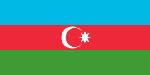
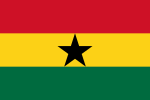
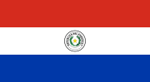
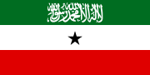
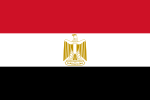
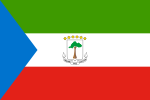
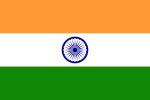
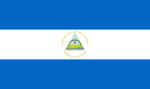
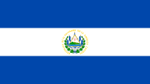
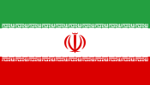
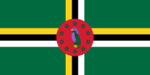
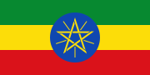
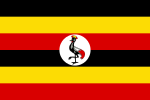
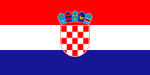
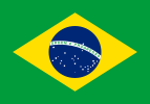
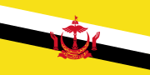
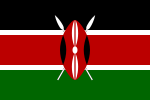
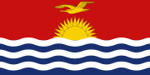
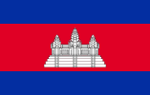
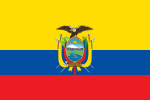
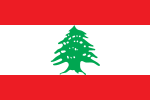
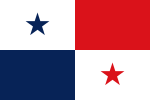
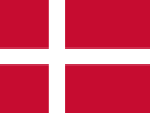
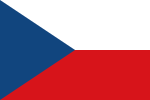
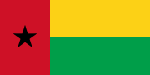
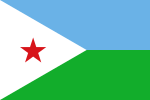
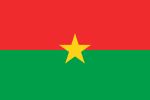
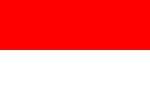
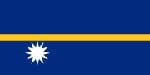
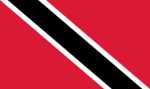
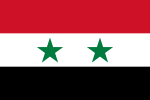
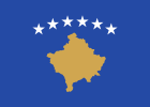
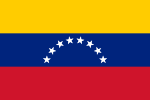
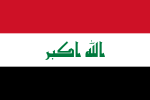
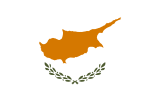
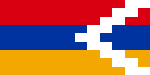
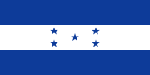
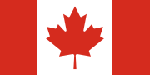
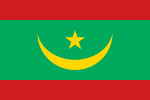
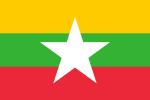
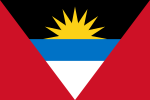
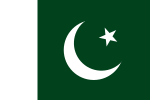
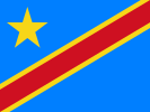
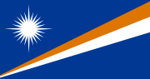
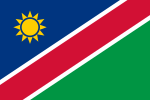
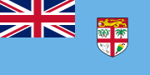

In [203]:
view_cluster(df, 'edge_cluster')

This clustering shows some useful components but is hardly perfect. One important factor is the seeming lack of inability to distinguish between background shape and insignia shape

# Combine colour and edge clusters

In [204]:
df

Country                               file     0     1     2     3  \
0           Iran         175px-Flag_of_Iran.svg.png   0.0   1.0  37.0  32.0   
1         Jordan       180px-Flag_of_Jordan.svg.png   0.0   0.0  20.0  25.0   
2        Georgia      150px-Flag_of_Georgia.svg.png   0.0   0.0  64.0  36.0   
3         Poland       160px-Flag_of_Poland.svg.png   0.0   0.0  50.0  50.0   
4           Fiji         180px-Flag_of_Fiji.svg.png   7.0   2.0  11.0  13.0   
..           ...                                ...   ...   ...   ...   ...   
201  Saint Lucia  180px-Flag_of_Saint_Lucia.svg.png   0.0   7.0   3.0   0.0   
202       Belize       167px-Flag_of_Belize.svg.png  64.0   1.0   9.0  21.0   
203     Colombia     150px-Flag_of_Colombia.svg.png  25.0  50.0   0.0  25.0   
204     Slovenia     180px-Flag_of_Slovenia.svg.png   0.0   0.0  32.0  34.0   
205     Pakistan     150px-Flag_of_Pakistan.svg.png   0.0   0.0  31.0   0.0   

        4     5     6  colour_cluster  edge_cluster  
0    29.0   0.0   2.0               9            25  
1    28.0  28.0   0.0              11             3  
2     0.0   0.0   0.0              18             4  
3     0.0   0.0   0.0              10             9  
4     1.0   0.0  66.0               3            30  
..    ...   ...   ...             ...           ...  
201   0.0   3.0  86.0               3            19  
202   4.0   0.0   1.0               4             0  
203   0.0   0.0   0.0               5            18  
204   0.0   0.0  34.0              17             1  
205   1.0  67.0   1.0               8            28  

[206 rows x 11 columns]

In [205]:
df['edge_cluster']=df['edge_cluster'].astype('str')
df['colour_cluster']=df['colour_cluster'].astype('str')

### Using colour percentages and edge cluster dummies

Originally it was not decided whether to use the above clusters for both colour and edge as some information could be lost.
Given that there was no choice about using edge clusters due to the way image recognition worked(that could be found in the deadline) it was better to use the same analysis for both.
The method of combined clustering using percentages for colour but cluster dummeis for shape is commented below for those who have interest

In [206]:
#df = pd.concat([df,pd.get_dummies(df['edge_cluster'], prefix='shape')],axis=1)

#combined=df.drop(['Country', 'file', 'colour_cluster', 'edge_cluster'], axis=1)

#combined

#X=scaler.fit_transform(combined)

In [207]:
#k_range = range(5, 100)
#scores= []
#inertia = []
#for k in k_range:
#    kmT= KMeans(n_clusters=k, random_state=124)
#    kmT.fit(X)
#    scores.append(metrics.silhouette_score(X, kmT.labels_))
#    inertia.append(kmT.inertia_)

In [208]:
#plt.plot(k_range, scores)

In [209]:
#plt.plot(k_range, inertia)

In [210]:
#z=list(zip(k_range, scores))
#for i in z:
#    print(i)

In [211]:
#cluster_size=14

#km = KMeans(n_clusters=cluster_size, random_state=124)
#km.fit(X)
#df['combined']=km.labels_

In [212]:
#view_cluster(df, 'combined')

### Using colour dummies and shape dummies

The two clusters generated above are turned into dummies so they can be combined for a final clustering

In [213]:
c=df[['colour_cluster', 'edge_cluster']]

In [214]:
c=pd.get_dummies(c)
c

colour_cluster_0  colour_cluster_1  colour_cluster_10  colour_cluster_11  \
0                   0                 0                  0                  0   
1                   0                 0                  0                  1   
2                   0                 0                  0                  0   
3                   0                 0                  1                  0   
4                   0                 0                  0                  0   
..                ...               ...                ...                ...   
201                 0                 0                  0                  0   
202                 0                 0                  0                  0   
203                 0                 0                  0                  0   
204                 0                 0                  0                  0   
205                 0                 0                  0                  0   

     colour_cluster_12  colour_cluster_13  colour_cluster_14  \
0                    0                  0                  0   
1                    0                  0                  0   
2                    0                  0                  0   
3                    0                  0                  0   
4                    0                  0                  0   
..                 ...                ...                ...   
201                  0                  0                  0   
202                  0                  0                  0   
203                  0                  0                  0   
204                  0                  0                  0   
205                  0                  0                  0   

     colour_cluster_15  colour_cluster_16  colour_cluster_17  ...  \
0                    0                  0                  0  ...   
1                    0                  0                  0  ...   
2                    0                  0                  0  ...   
3                    0                  0                  0  ...   
4                    0                  0                  0  ...   
..                 ...                ...                ...  ...   
201                  0                  0                  0  ...   
202                  0                  0                  0  ...   
203                  0                  0                  0  ...   
204                  0                  0                  1  ...   
205                  0                  0                  0  ...   

     edge_cluster_28  edge_cluster_29  edge_cluster_3  edge_cluster_30  \
0                  0                0               0                0   
1                  0                0               1                0   
2                  0                0               0                0   
3                  0                0               0                0   
4                  0                0               0                1   
..               ...              ...             ...              ...   
201                0                0               0                0   
202                0                0               0                0   
203                0                0               0                0   
204                0                0               0                0   
205                1                0               0                0   

     edge_cluster_4  edge_cluster_5  edge_cluster_6  edge_cluster_7  \
0                 0               0               0               0   
1                 0               0               0               0   
2                 1               0               0               0   
3                 0               0               0               0   
4                 0               0               0               0   
..              ...             ...             ...             ...   
201               0               0             

In [215]:
X=scaler.fit_transform(c)

In [216]:
k_range = range(5, 100)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(X)
    scores.append(metrics.silhouette_score(X, kmT.labels_))
    inertia.append(kmT.inertia_)

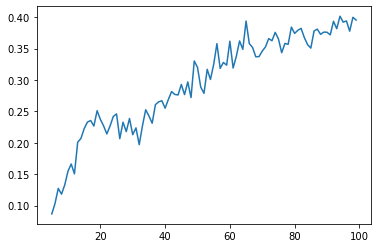

In [217]:
plt.plot(k_range, scores)

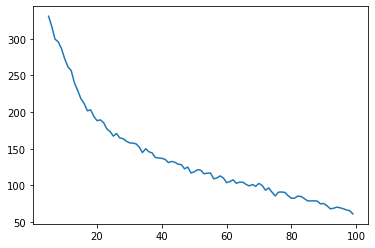

In [218]:
plt.plot(k_range, inertia)

In [219]:
#z=list(zip(k_range, scores))
#for i in z:
#    print(i)

In [220]:
cluster_size=25

In [221]:
km = KMeans(n_clusters=cluster_size, random_state=124)
km.fit(X)
df['combined2']=km.labels_

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: FutureWarning:

The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.




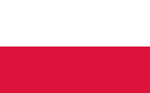
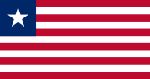
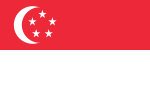
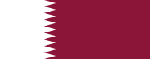
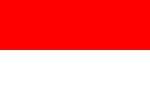
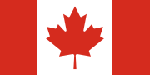
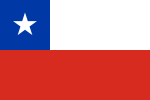
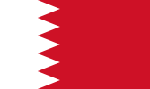
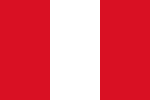
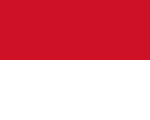
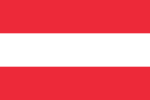
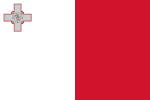
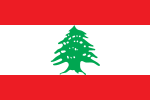
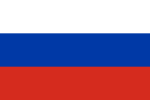
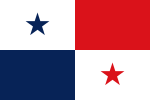
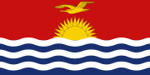
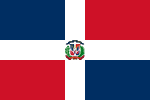
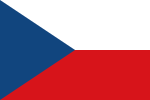
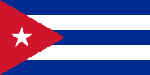
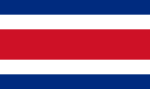
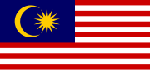
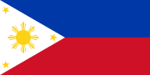
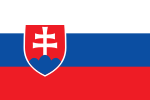
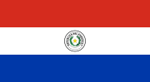
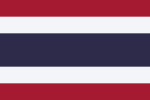
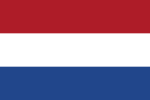
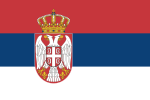
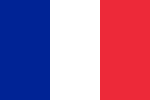
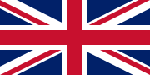
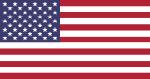
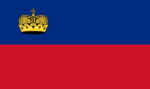
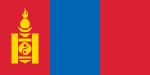
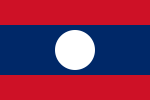
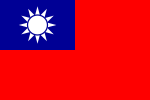
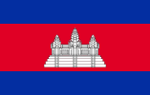
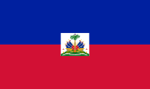
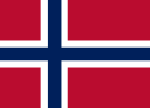
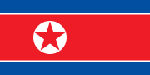
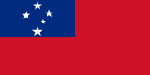
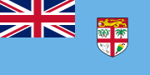
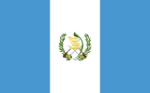
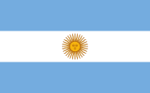
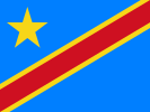
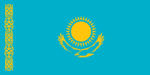
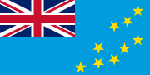
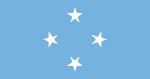
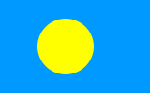
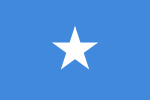
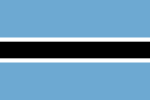
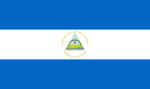
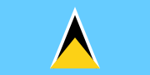
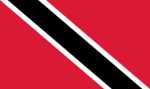
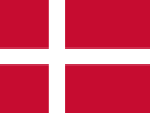
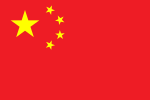
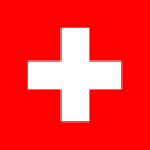
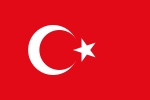
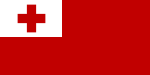
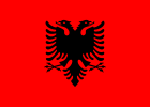
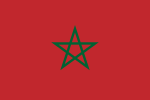
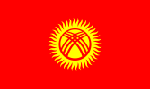
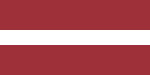
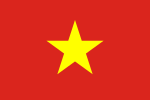
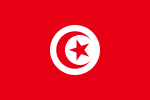
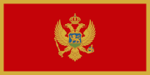
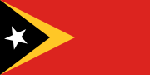
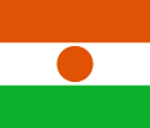
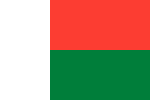
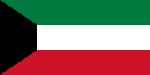
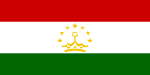
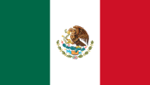
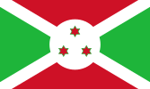
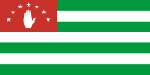
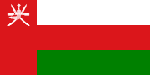
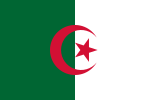
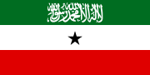
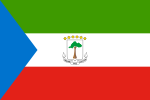
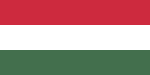
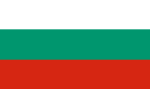
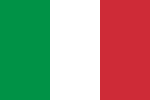
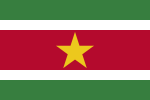
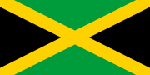
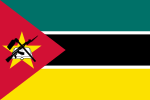
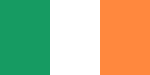
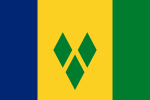
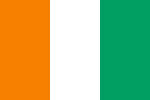
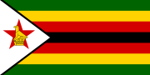
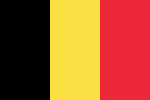
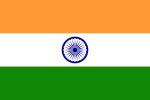
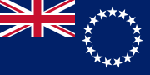
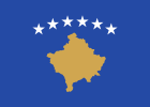
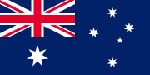
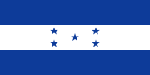
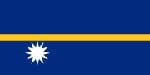
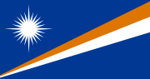
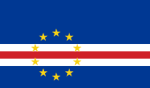
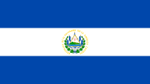
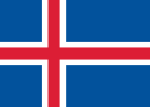
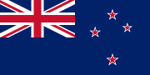
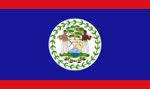
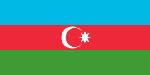
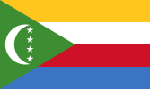
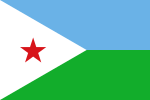
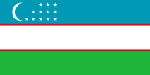
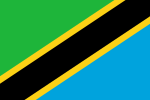
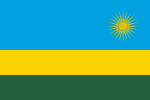
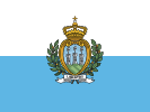
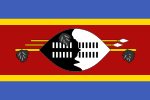
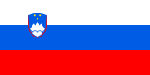
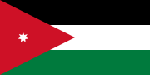
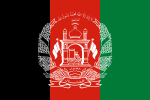
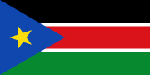
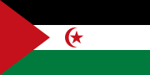
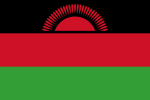
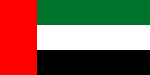
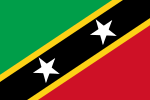
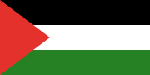
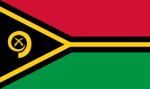
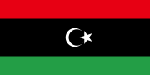
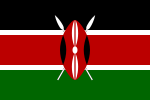
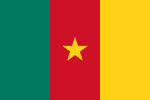
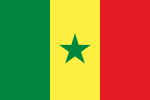
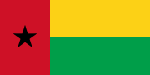
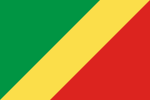
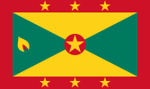
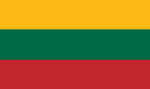
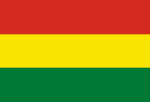
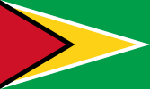
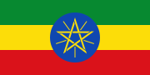
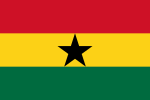
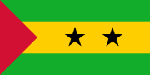
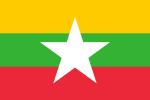
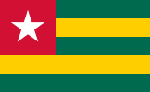
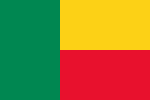
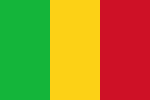
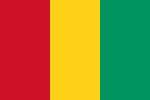
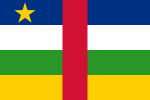
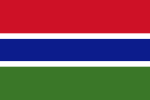
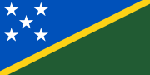
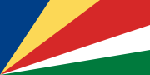
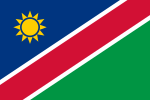
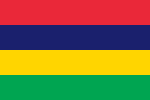
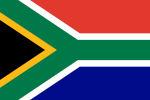
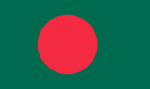
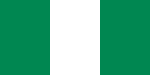
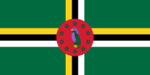
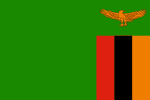
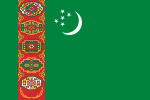
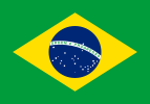
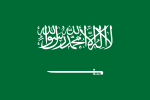
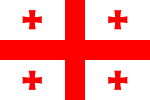
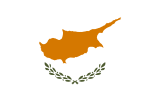
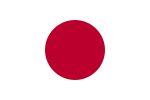
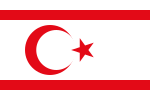
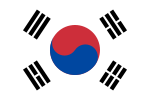
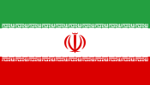
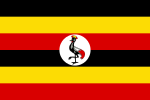
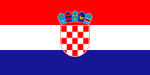
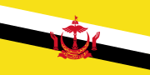
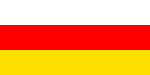
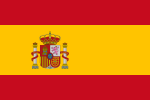
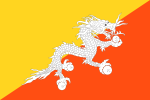
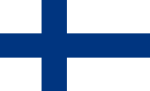
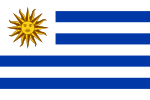
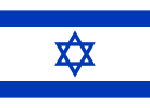
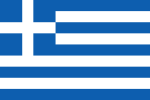
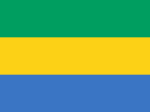
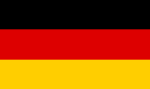
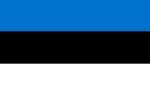
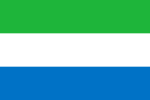
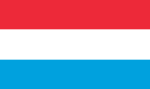
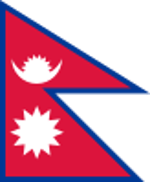
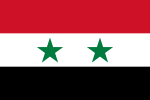
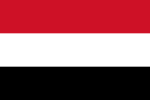
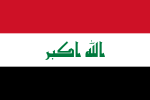
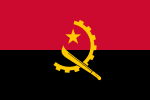
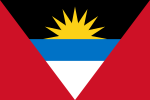
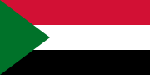
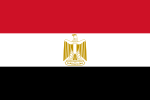
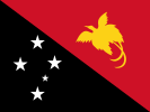
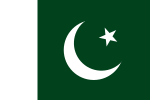
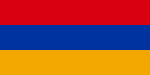
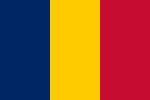
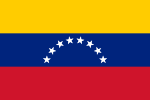
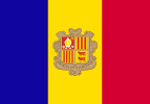
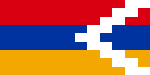
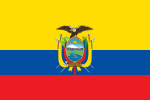
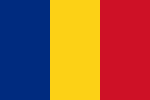
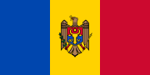
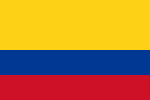
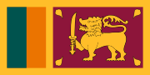
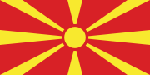
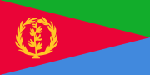
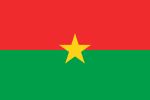
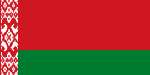
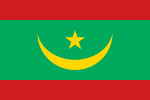
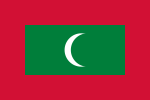
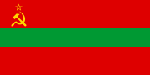
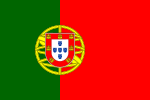
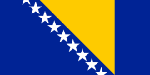
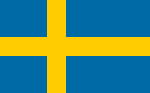
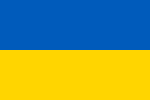
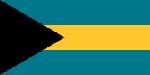
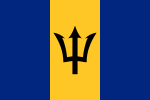
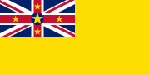
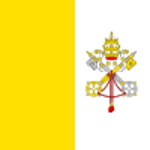
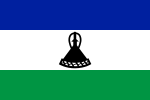


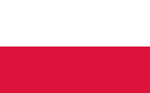
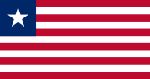
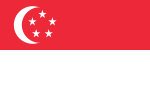
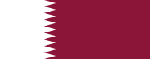
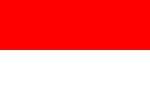
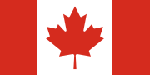
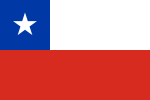
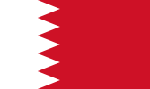
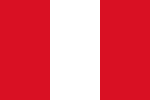
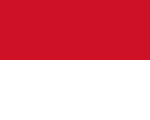
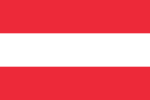
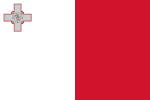
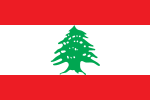
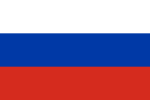
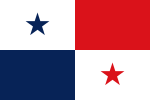
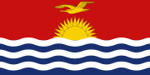
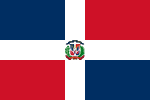
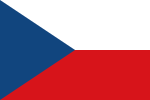
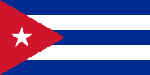
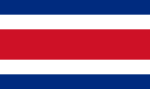
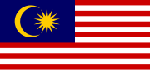
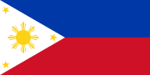
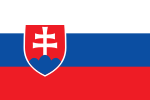
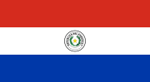
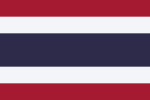
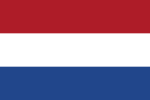
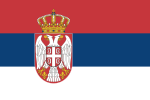
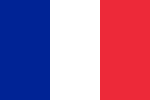
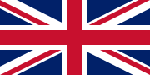
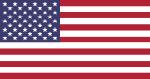
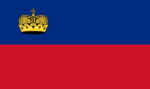
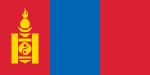
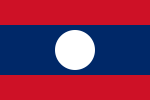
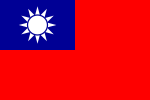
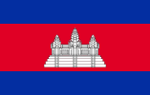
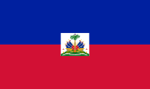
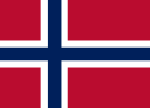
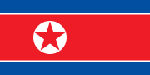
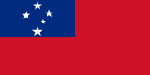
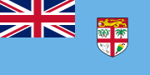
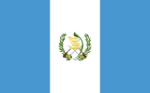
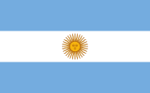
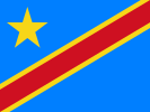
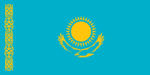
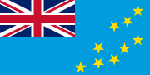
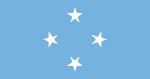
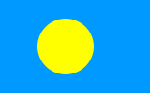
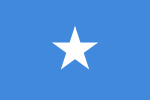
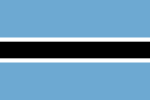
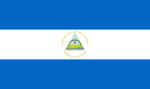
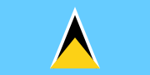
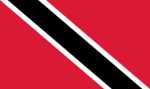
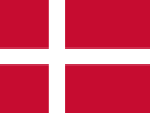
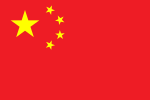
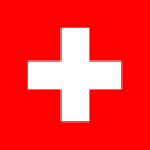
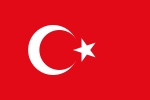
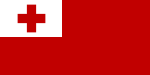
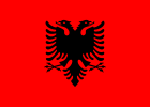
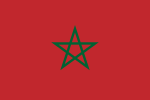
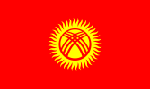
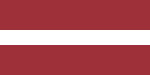
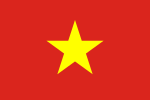
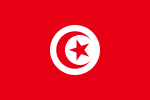
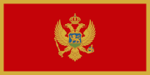
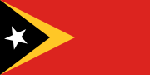
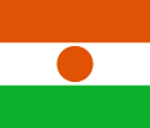
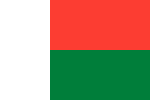
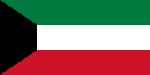
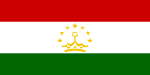
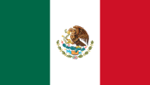
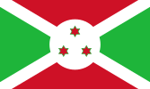
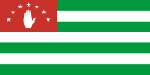
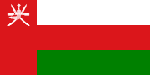
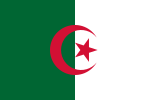
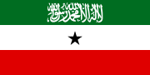
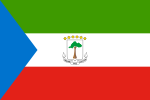
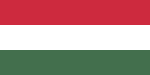
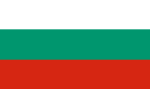
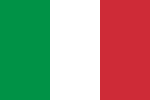
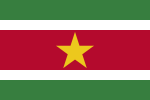
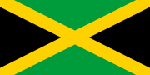
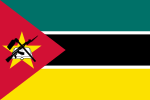
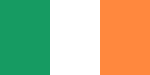
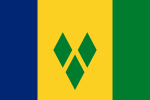
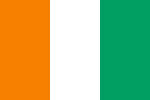
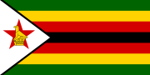
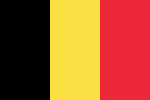
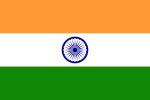
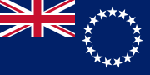
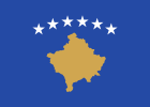
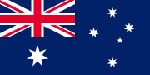
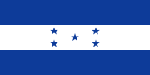
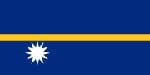
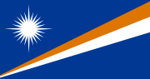
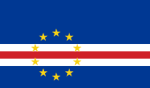
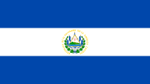
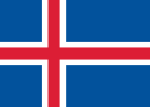
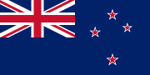
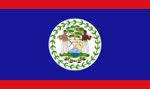
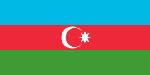
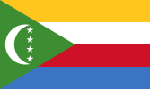
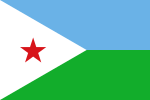
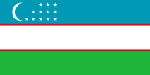
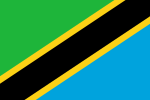
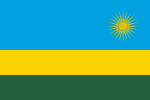
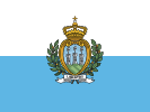
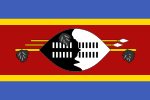
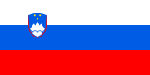
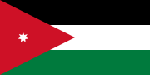
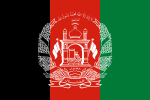
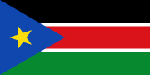
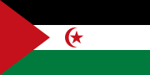
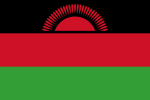
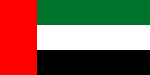
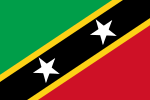
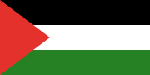
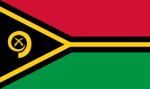
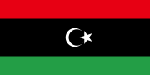
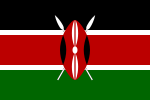
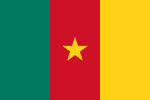
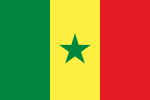
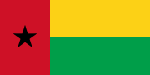
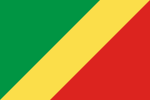
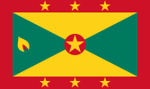
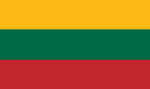
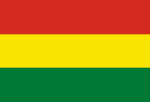
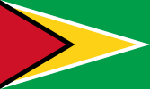
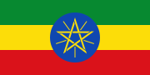
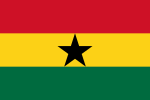
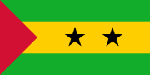
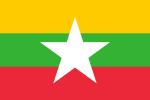
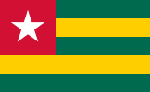
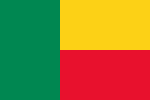
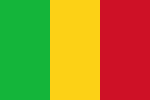
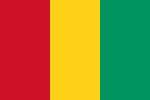
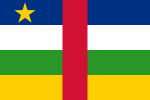
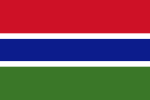
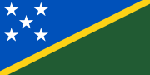
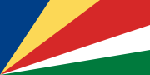
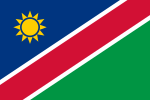
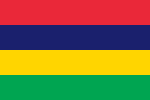
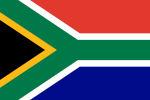
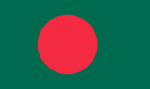
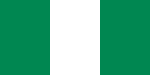
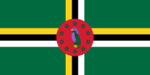
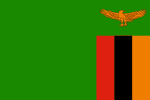
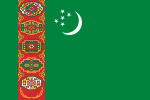
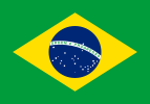
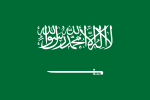
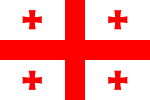
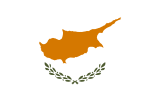
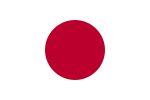
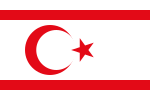
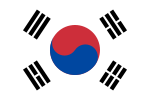
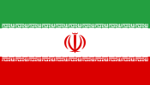
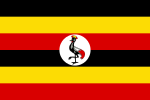
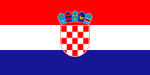
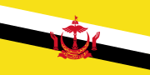
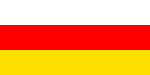
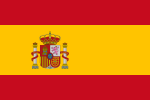
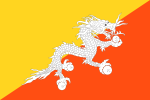
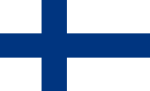
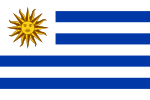
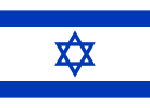
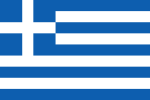
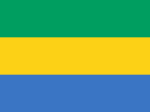
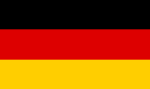
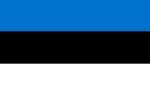
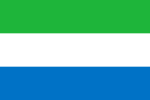
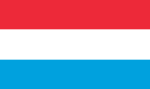
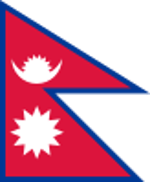
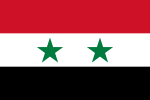
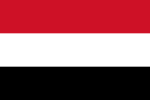
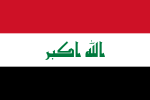
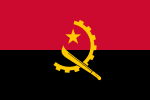
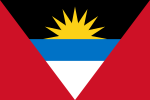
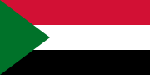
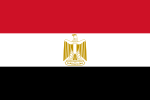
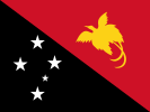
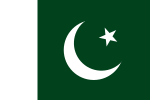
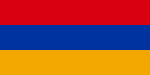
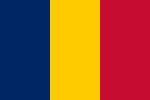
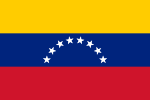
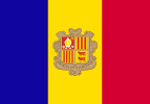
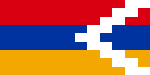
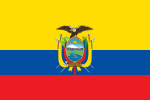
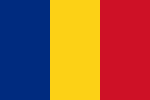
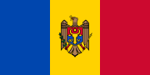
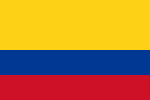
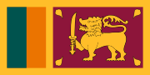
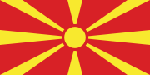
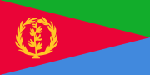
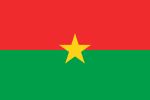
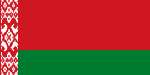
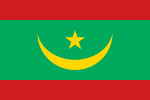
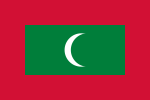
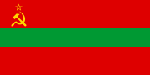
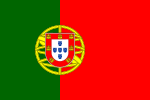
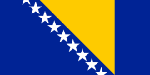
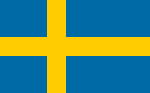
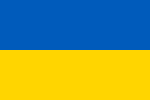
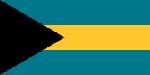
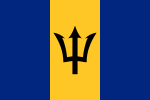
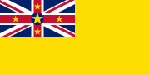
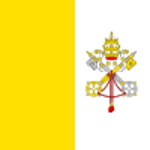
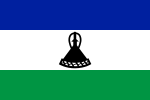

In [222]:
view_cluster(df, 'combined2')

This final cluster is not terribly good due to a lack of control over whether colour or shape is the more important component for clustering, which is important in many cases.
As this cannot be controlled in an unsupervised environment, there follows an attempt at introducing some supervision.

# Supervised

In [223]:
df_s=df[['Country', 'edge_cluster', 'colour_cluster']]

## Drop useless Columns

This is a quick list of some clusters generated by colour and shape that appear to contain no useful information and should not be relied upon for further clustering

In [224]:
bad_c=['Denmark', 'Greece', 'Sweden', 'Brazil', 'Jamaica', 'Brunei', 'Japan', 'Spain']
bad1=df_s[df_s['Country'].isin(bad_c)]['colour_cluster'].tolist()

bad_e=['Cyprus', 'Jamaica', 'Lebanon', 'Ethiopia', 'Rwanda', 'Panama']
bad2=df_s[df_s['Country'].isin(bad_e)]['edge_cluster'].tolist()

## Manually add groups

Some flags have very clear grouping with other flags.
Where they are defined new columns are created to force clustering

In [225]:
# Set value to 10 to prioritise known groups

In [226]:
# Pan-arab
ARA=['Egypt', 'Iraq', 'Jordan', 'Kuwait', 'Pelestine', 'Sudan', 'Syria', 'United Arab Emirates', 'Yemen', 'the Sahrawi Arab Democratic Republic']
df_s['Pan-Arab']=0
df_s.loc[df['Country'].isin(ARA), 'Pan-Arab']=10
# Pan-African
# There are two overlapping  set of pan-african flags
AFR=['Zimbabawe', 'Ethiopia', 'Ghana', 'Burkina Faso', 'Cameroon', 'Comoros', 'Central African Republic', 'the Republic of the Congo', 'Eritrea', 'Benin', 'Chad', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique', 'Namibia', 'Sao Tome and Principe', 'Seychelles', 'Senegal', 'South Africa', 'South Sudan', 'Togo', 'Zambia']
df_s['Pan-African']=0
df_s.loc[df['Country'].isin(AFR), 'Pan-African']=10
# Pan Slavic
SLV=['Croatia', 'Russia', 'Slovenia', 'Serbia', 'Slovakia', 'the Czech Republic']
df_s['Pan-Slavic']=0
df_s.loc[df['Country'].isin(SLV), 'Pan-Slavic']=10
# Scandinavian
SCD=['Norway', 'Sweden', 'Finalnd', 'Iceland', 'Denmark']
df_s['Nordic Cross']=0
df_s.loc[df['Country'].isin(SCD), 'Nordic Cross']=10
# British Canton
BRT=['Fiji', 'Australia', 'New Zealand', 'Tuvalu', 'Niue', 'the Cook Islands']
df_s['British Canton']=0
df_s.loc[df['Country'].isin(BRT), 'British Canton']=10

<ipython-input-226-616550ede599>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-226-616550ede599>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [227]:
df_s = pd.concat([df_s,pd.get_dummies(df_s[['colour_cluster', 'edge_cluster']], prefix=['colour', 'shape'])],axis=1)
df_s=df_s.drop(['Country', 'edge_cluster', 'colour_cluster'], axis=1)

In [228]:
for i in bad1:
    #print(i)
    df_s=df_s.drop('colour_'+str(i), axis=1)
for i in bad2:
    #print(i)
    df_s=df_s.drop('shape_'+str(i), axis=1)

In [229]:
df_s

Pan-Arab  Pan-African  Pan-Slavic  Nordic Cross  British Canton  \
0           0            0           0             0               0   
1          10            0           0             0               0   
2           0            0           0             0               0   
3           0            0           0             0               0   
4           0            0           0             0              10   
..        ...          ...         ...           ...             ...   
201         0            0           0             0               0   
202         0            0           0             0               0   
203         0            0           0             0               0   
204         0            0          10             0               0   
205         0            0           0             0               0   

     colour_1  colour_10  colour_11  colour_12  colour_17  ...  shape_24  \
0           0          0          0          0          0  ...         0   
1           0          0          1          0          0  ...         0   
2           0          0          0          0          0  ...         0   
3           0          1          0          0          0  ...         0   
4           0          0          0          0          0  ...         0   
..        ...        ...        ...        ...        ...  ...       ...   
201         0          0          0          0          0  ...         0   
202         0          0          0          0          0  ...         0   
203         0          0          0          0          0  ...         0   
204         0          0          0          0          1  ...         0   
205         0          0          0          0          0  ...         0   

     shape_29  shape_3  shape_30  shape_4  shape_5  shape_6  shape_7  shape_8  \
0           0        0         0        0        0        0        0        0   
1           0        1         0        0        0        0        0        0   
2           0        0         0        1        0        0        0        0   
3           0        0         0        0        0        0        0        0   
4           0        0         1        0        0        0        0        0   
..        ...      ...       ...      ...      ...      ...      ...      ...   
201         0        0         0        0        0        0        0        0   
202         0        0         0        0        0        0        0        0   
203         0        0         0        0        0        0        0        0   
204         0        0         0        0        0        0        0        0   
205         0        0         0        0        0        0        0        0   

     shape_9  
0          0  
1          0  
2          0  
3          1  
4          0  
..       ...  
201        0  
202        0  
203        0  
204        0  
205        0  

[206 rows x 44 columns]

In [230]:
X=df_s

In [231]:
k_range = range(5, 100)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(X)
    scores.append(metrics.silhouette_score(X, kmT.labels_))
    inertia.append(kmT.inertia_)

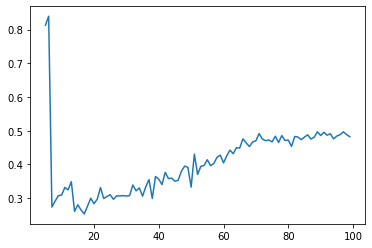

In [232]:
plt.plot(k_range, scores)

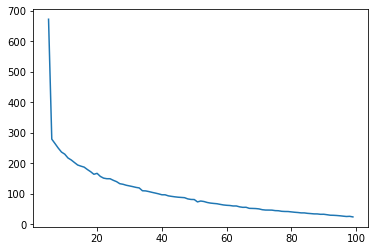

In [233]:
plt.plot(k_range, inertia)

In [234]:
#z=list(zip(k_range, scores))
#for i in z:
#    print(i)

In [235]:
cluster_size=17

In [236]:
km = KMeans(n_clusters=cluster_size, random_state=124)
km.fit(X)
df['Supervised']=km.labels_

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: FutureWarning:

The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.




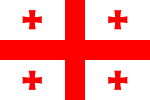
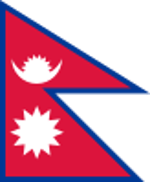
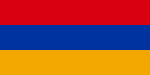
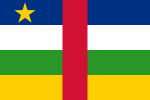
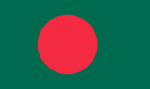
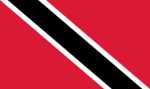
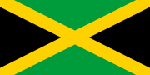
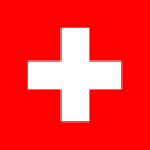
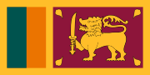
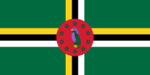
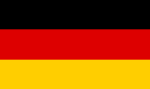
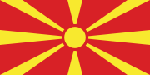
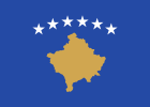
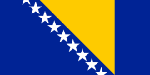
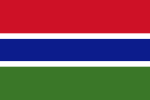
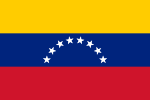
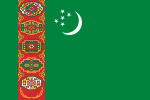
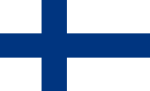
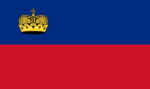
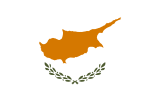
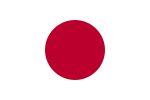
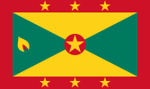
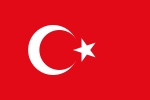
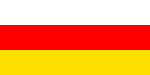
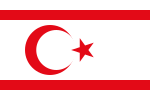
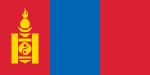
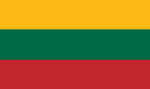
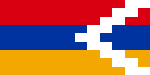
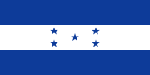
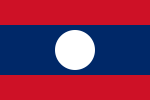
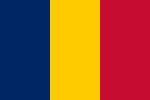
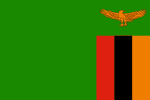
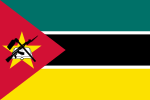
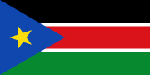
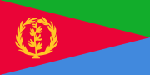
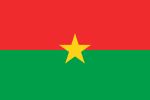
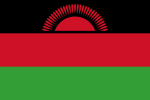
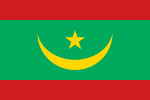
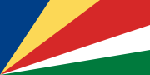
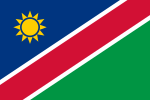
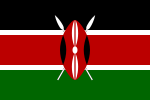
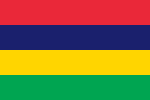
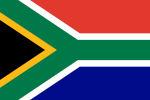
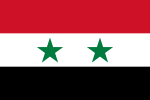
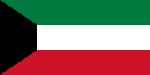
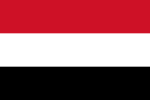
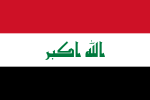
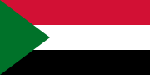
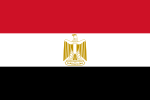
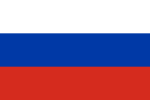
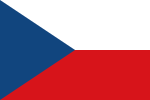
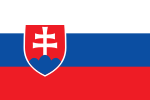
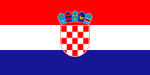
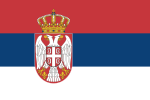
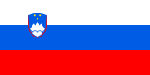
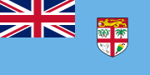
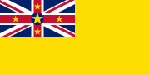
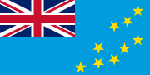
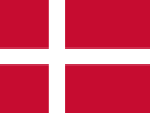
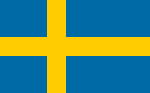
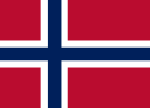
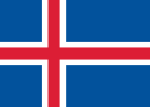
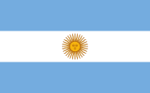
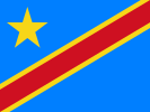
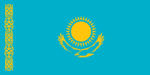
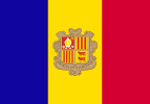
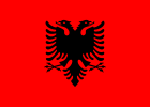
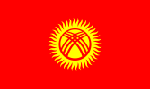
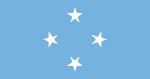
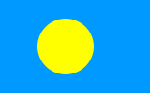
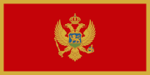
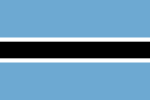
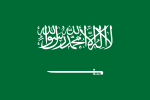
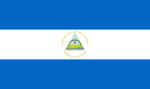
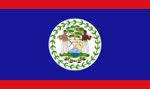
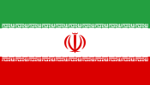
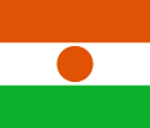
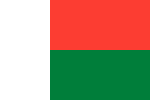
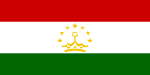
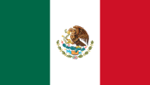
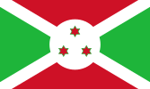
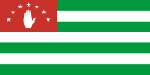
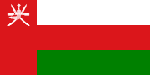
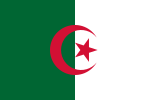
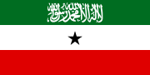
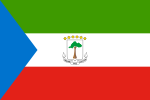
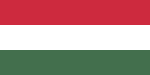
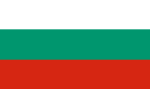
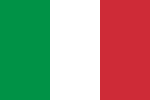
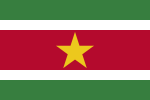
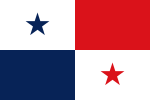
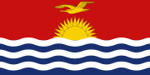
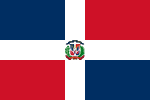
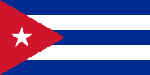
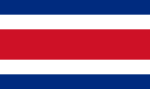
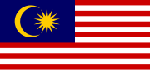
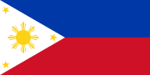
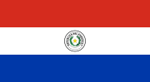
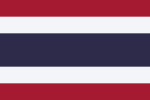
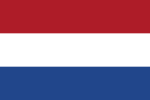
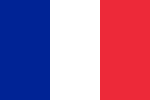
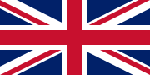
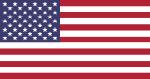
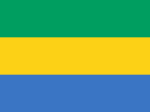
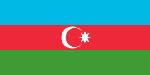
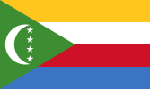
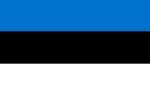
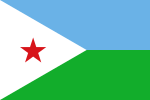
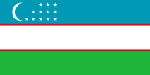
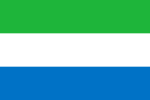
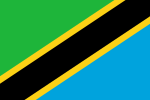
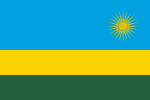
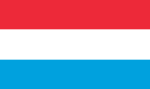
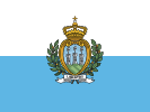
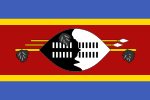
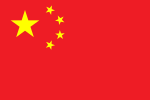
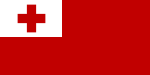
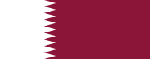
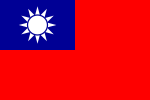
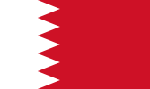
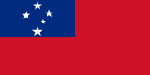
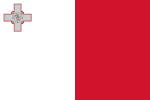
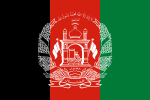
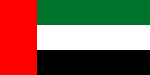
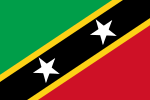
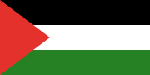
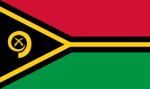
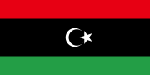
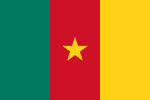
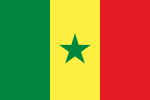
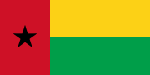
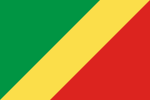
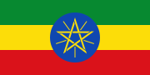
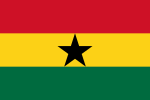
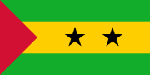
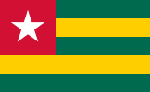
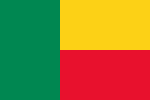
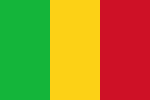
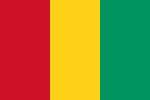
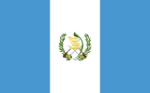
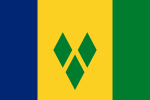
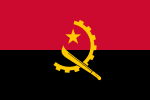
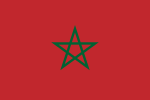
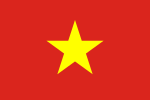
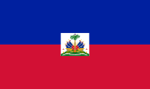
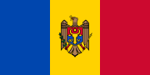
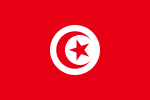
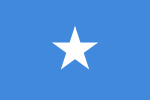
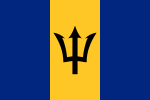
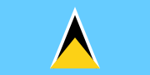
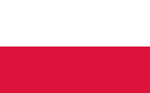
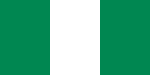
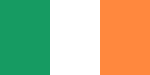
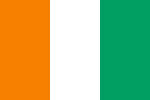
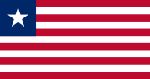
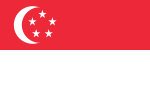
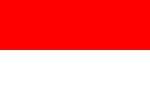
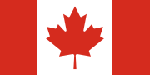
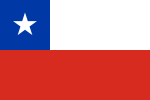
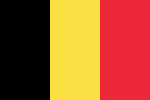
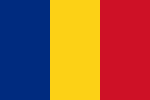
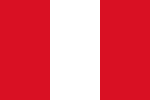
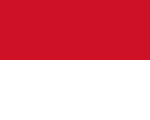
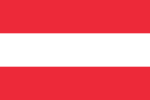
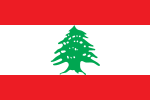
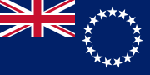
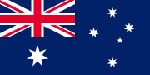
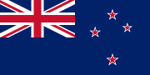
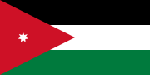
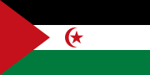


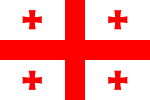
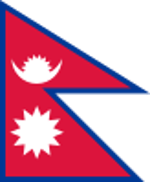
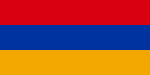
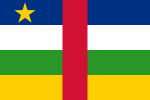
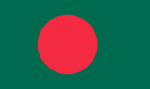
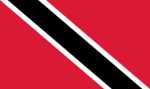
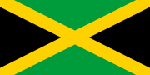
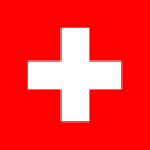
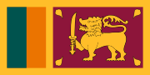
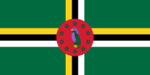
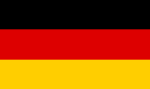
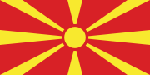
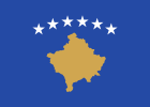
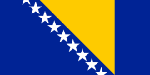
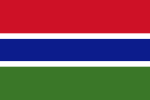
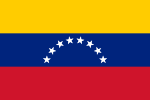
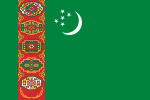
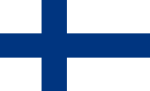
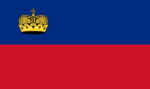
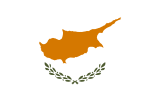
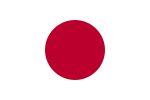
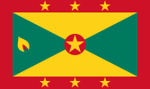
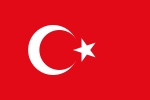
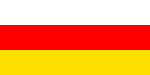
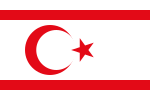
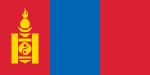
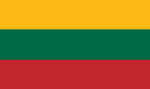
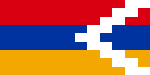
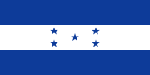
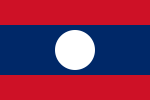
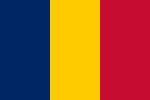
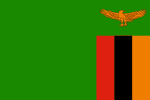
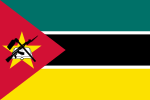
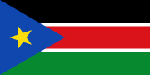
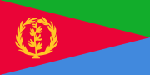
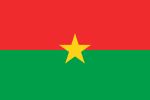
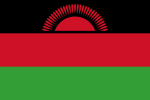
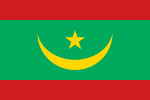
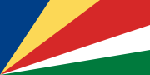
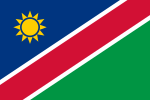
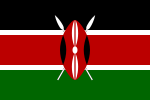
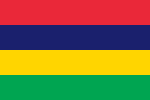
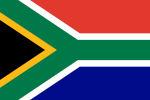
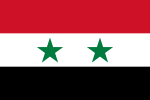
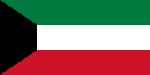
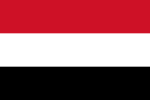
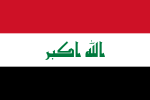
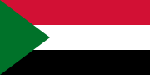
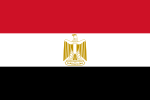
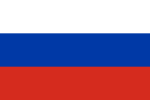
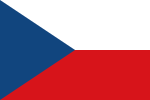
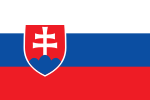
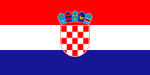
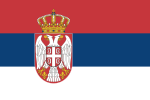
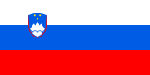
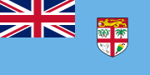
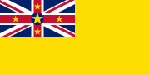
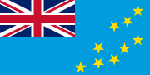
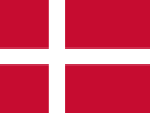
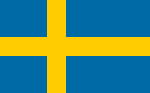
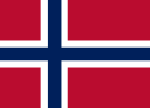
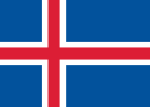
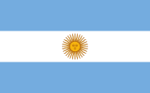
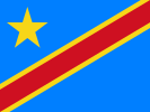
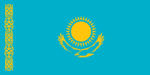
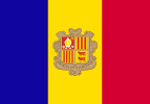
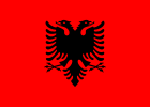
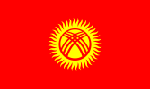
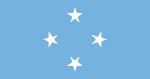
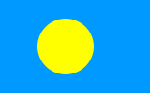
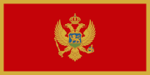
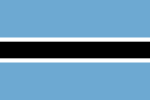
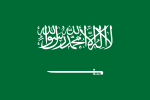
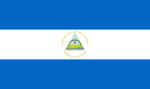
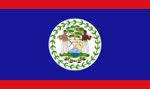
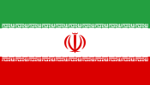
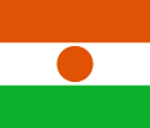
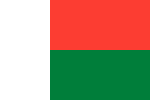
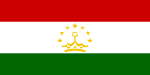
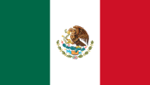
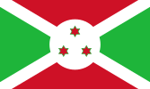
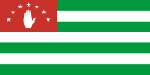
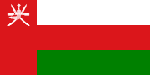
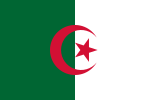
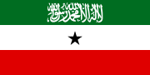
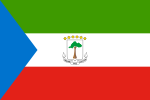
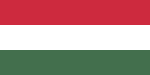
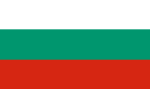
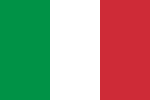
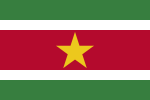
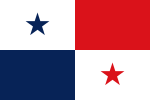
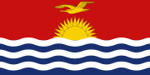
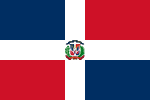
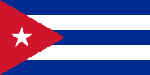
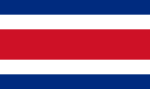
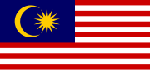
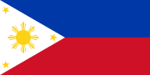
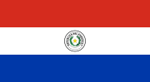
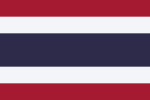
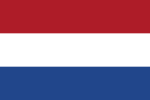
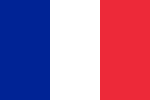
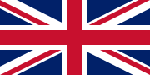
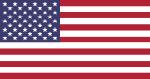
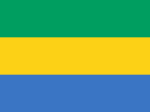
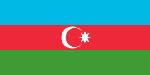
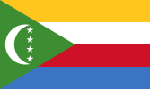
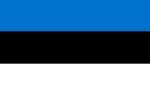
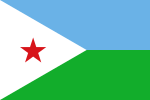
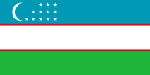
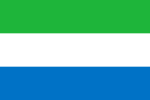
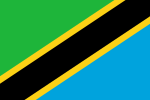
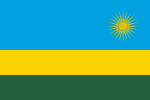
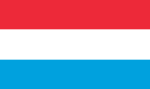
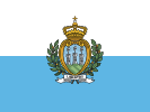
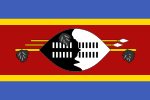
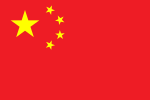
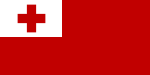
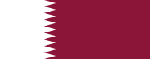
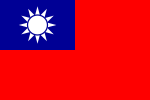
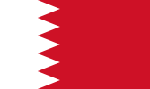
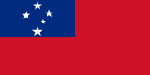
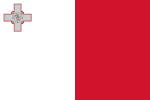
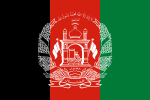
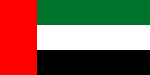
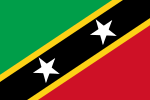
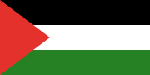
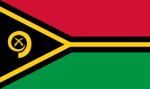
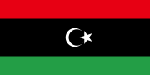
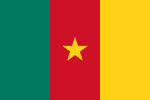
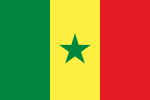
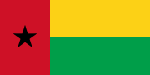
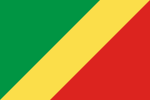
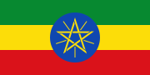
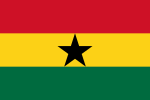
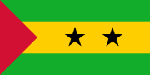
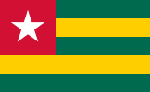
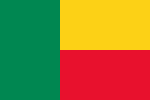
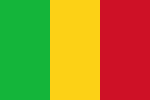
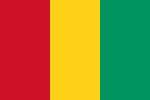
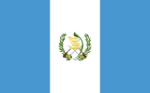
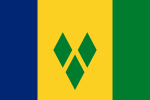
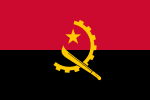
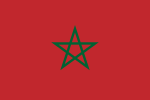
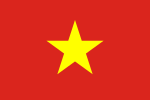
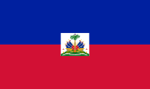
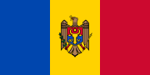
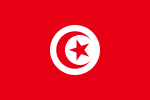
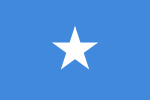
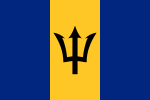
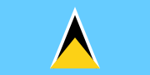
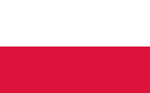
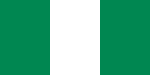
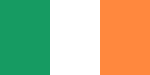
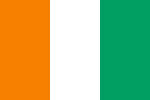
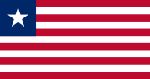
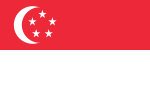
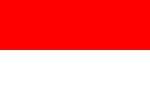
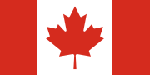
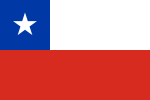
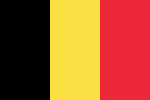
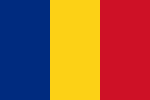
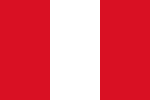
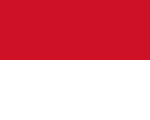
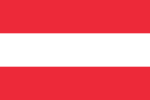
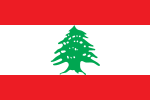
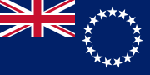
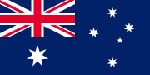
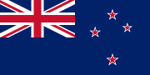
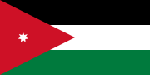
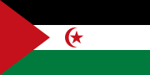

In [237]:
view_cluster(df, 'Supervised')